<b>Data mining Project - 2021/22</b><br/>
<span>
<b>Authors:</b> Mariagiovanna Rotundo (560765), Nunzio Lopardo (600005)</a> and Renato Eschini (203021)<br/>
<b>Group:</b>3<br/>
<b>Release date:</b> 26/12/2021
</span>

# Data Preparation

In this notebook we modify the tennis dataset according observation done in the understanding phase and we create a dataset of players

**Import libraries**

In [1]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import collections
from scipy.stats.stats import pearsonr
import pandas as pd
import os
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns
import re

In [2]:
#import functions from ipynb file
from ipynb.fs.full.functions_understanding import *

**Loading datasets**

In [3]:
# load of the data
DATASET_DIR = '..' + os.path.sep + "dataset" + os.path.sep
df_tennis = pd.read_csv(DATASET_DIR + 'tennis_matches.csv', sep=',', index_col=0) 

#index_col=False say to not use the first column as ID
df_male = pd.read_csv(DATASET_DIR + 'male_players.csv', sep=',', index_col=False)
df_female = pd.read_csv(DATASET_DIR + 'female_players.csv', sep=',', index_col=False) 

#### Remove rows that have only null values

In [4]:
#remove null rows
df_male.dropna(how='all', inplace=True)
df_female.dropna(how='all', inplace=True)
df_tennis.dropna(how='all', inplace=True)

## Male and female datasets

**romove duplicate rows in male and female dataset**

In [5]:
#remove duplicates in the separate datasets
df_male.drop_duplicates(keep='first', inplace=True)
df_female.drop_duplicates(keep='first', inplace=True)

#### male: correction invalid names/surnames

The null values in name/surname are replaced with the value "unknown"

In [6]:
#rows with nulls in name: replace null with unknown
df_male.loc[df_male['name'].isna(), ['name']]='unknown'
df_male['name'].isna().sum(axis = 0)

0

In [7]:
#rows with nulls in surname: replace null with unknown
df_male.loc[df_male['surname'].isna(), ['surname']]='unknown'
df_male['surname'].isna().sum(axis = 0)

0

If a row is read in a wrong way by pandas putting all in the name, the row is splitted in name and surname updating both. The name and surname are split looking at "," that is the separator used in the dataset.

In [8]:
#errors reading from file: all in name and null surname (replaced with unknown)
df_male[df_male['name'].str.contains(",")]
for index, row in df_male[df_male['name'].str.contains(",")].iterrows():
    if row['surname']=='unknown':
        name = row['name'].split(",")
        df_male.at[index,'surname']=name[len(name)-1]
        df_male.at[index,'name']=' '.join(name[0:len(name)-1])
        
#print(df_male.loc[40071])

Correction of invalid characters in name and surname columns. If the value has not alphabetich characters the value is considered as "unknown". If in the name there are numbers or special characters different from ",", " ' ", "-", "\_", ".", these are removed. if in the surname there are strings between "()" these are removed. All the other not alphabetic characters are replaced with a space and double spaces are removed. This checks are done for both male and female dataset to find duplicate players with invalid characters between characters.

In [9]:
#names/surnames without any letters are invalid: set to unknown
df_male.loc[~df_male['name'].str.contains("[a-zA-Z]"), ['name']]='unknown'
df_male.loc[~df_male['surname'].str.contains("[a-zA-Z]"), ['surname']]='unknown'

#replace numbers in names
df_male["name"] = df_male["name"].str.replace("[0-9]","",regex=True)
df_male["surname"] = df_male["surname"].str.replace("[0-9]","",regex=True)

#characters not indicated in the expression are considered invalid
df_male["name"] = df_male["name"].str.replace("[^a-zA-Z ',-_.]","",regex=True)
#for surname remove string between ()
for index, row in  df_male[df_male['surname'].str.contains('\(')].iterrows():
    pos = df_male.at[index,'surname'].find("(")
    df_male.at[index,'surname']= df_male.at[index,'surname'][0:pos]
df_male["surname"] = df_male["surname"].str.replace("[^a-zA-Z ',-._]","",regex=True)

#replace allowed 
df_male["name"] = df_male["name"].str.replace("[^a-zA-Z ]"," ",regex=True)
df_male["surname"] = df_male["surname"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_male["name"] = df_male["name"].str.strip()
df_male["surname"] = df_male["surname"].str.strip()

After these changes we look for new duplicates introduced because of changes. Then we romove rows with both name and surname unknown.

In [10]:
#check if duplicates are been introduced
df_male.duplicated(keep='first').sum()

14

In [11]:
#remove duplicates
df_male.drop_duplicates(keep='first', inplace=True)

In [12]:
#remove (if there is) the row <unknown unknown>
row = df_male.index[(df_male['name'].str.lower()=='unknown') & (df_male['surname'].str.lower()=='unknown')].tolist()
df_male.drop(row, inplace=True)

#### female: correction invalid names/surnames

For the female dataset the same checks for the male one are done

In [13]:
#rows with nulls in name: replace null with unknown
df_female.loc[df_female['name'].isna(), ['name']]='unknown'
df_female['name'].isna().sum(axis = 0)

0

In [14]:
#rows with nulls in surname: replace null with unknown
df_female.loc[df_female['surname'].isna(), ['surname']]='unknown'
df_female['surname'].isna().sum(axis = 0)

0

In [15]:
#errors reading from file: all in name and null surname (replaced with unknown)
df_female[df_female['name'].str.contains(",")]
for index, row in df_female[df_female['name'].str.contains(",")].iterrows():
    if row['surname']=='unknown':
        name = row['name'].split(",")
        df_female.at[index,'surname']=name[len(name)-1]
        df_female.at[index,'name']=' '.join(name[0:len(name)-1])

In [16]:
#names/surnames without any letters are invalid: set to unknown
df_female.loc[~df_female['name'].str.contains("[a-zA-Z]"), ['name']]='unknown'
df_female.loc[~df_female['surname'].str.contains("[a-zA-Z]"), ['surname']]='unknown'

#replace numbers in names
df_female["name"] = df_female["name"].str.replace("[0-9]","",regex=True)
df_female["surname"] = df_female["surname"].str.replace("[0-9]","",regex=True)

#characters not indicated in the expression are considered invalid
df_female["name"] = df_female["name"].str.replace("[^a-zA-Z ',-_.]","",regex=True)
#for surname remove string between ()
for index, row in  df_female[df_female['surname'].str.contains('\(')].iterrows():
    pos = df_female.at[index,'surname'].find("(")
    df_female.at[index,'surname']= df_female.at[index,'surname'][0:pos]
df_female["surname"] = df_female["surname"].str.replace("[^a-zA-Z ',-._]","",regex=True)

#replace allowed 
df_female["name"] = df_female["name"].str.replace("[^a-zA-Z ]"," ",regex=True)
df_female["surname"] = df_female["surname"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_female["name"] = df_female["name"].str.strip()
df_female["surname"] = df_female["surname"].str.strip()

In [17]:
#check if duplicates are been introduced
df_female.duplicated(keep='first').sum()

1

In [18]:
#remove duplicates
df_female.drop_duplicates(keep='first', inplace=True)

In [19]:
#remove (if there is) the row <unknown unknown>
row = df_female.index[(df_female['name'].str.lower()=='unknown') & (df_female['surname'].str.lower()=='unknown')].tolist()
df_female.drop(row, inplace=True)

#### Player dataset

Creation of a dataset of players. A row for each player (name + surname) is created. Creation of columns of name (name + surname) and sex retrieved by datasets male and female looking in which of the 2 the player is. If a player is in both male and female dataset the sex in considered unknown ("U"). If name or surname are unknown only the value in the other column is considered.

In [20]:
df_male['whole_name'] = df_male['name']+" "+df_male['surname']
df_male['sex']='M'
df_female['whole_name'] = df_female['name']+" "+df_female['surname']
df_female['sex']='F'

In [21]:
#creation of the dataset of the player including the information about sex
df_players = pd.concat([df_male, df_female])

In [22]:
#see if a name can be both male and female and manage them
df_players.loc[df_players.duplicated(subset=['name','surname'],keep=False)==True, ['sex']]='U'
df_players.drop_duplicates(keep='first', inplace=True)
df_players

,name,surname,whole_name,sex
0,Gardnar,Mulloy,Gardnar Mulloy,M
1,Pancho,Segura,Pancho Segura,M
2,Frank,Sedgman,Frank Sedgman,M
3,Giuseppe,Merlo,Giuseppe Merlo,M
4,Richard Pancho,Gonzales,Richard Pancho Gonzales,M
...,...,...,...,...
46167,Kathleen,Allen,Kathleen Allen,F
46168,Mrs,Dransfield,Mrs Dransfield,F
46169,Jessie,Greene,Jessie Greene,F
46170,Mary,Trumbull,Mary Trumbull,F


In [23]:
for index, row in df_players[df_players['name']=='unknown'].iterrows():
    df_players.loc[index, 'whole_name'] = row['surname']

In [24]:
for index, row in df_players[df_players['surname']=='unknown'].iterrows():
    df_players.loc[index, 'whole_name'] = row['name']

## Tennis dataset

Remove duplicate rown in tennis dataset

In [25]:
df_tennis.drop_duplicates(keep='first', inplace=True)

#### tourney_id

The tourney id that are null are replaced with the "unknown" value

In [26]:
df_tennis['tourney_id'].isna().sum(axis = 0)
df_tennis.loc[df_tennis['tourney_id'].isna(), ['tourney_id']]='unknown'

#### winner_name and loser_name

For the winner and loser name the same changes of the male and female dataset are done to have the names with the same structure.

In [27]:
#rows with nulls in name: replace null with unknown
df_tennis.loc[df_tennis['winner_name'].isna(), ['winner_name']]='unknown'
df_tennis['winner_name'].isna().sum(axis = 0)

df_tennis.loc[df_tennis['loser_name'].isna(), ['loser_name']]='unknown'
df_tennis['loser_name'].isna().sum(axis = 0)

0

In [28]:
#nameswithout any letters are invalid: set to unknown
df_tennis.loc[~df_tennis['winner_name'].str.contains("[a-zA-Z]"), ['winner_name']]='unknown'
df_tennis.loc[~df_tennis['loser_name'].str.contains("[a-zA-Z]"), ['loser_name']]='unknown'

#replace numbers in names
df_tennis["winner_name"] = df_tennis["winner_name"].str.replace("[0-9]","",regex=True)
df_tennis["loser_name"] = df_tennis["loser_name"].str.replace("[0-9]","",regex=True)

#remove string between ()
for index, row in  df_tennis[df_tennis['winner_name'].str.contains('\(')].iterrows():
    pos = df_tennis.at[index,'winner_name'].find("(")
    df_tennis.at[index,'winner_name']= df_tennis.at[index,'winner_name'][0:pos]
for index, row in  df_tennis[df_tennis['loser_name'].str.contains('\(')].iterrows():
    pos = df_tennis.at[index,'loser_name'].find("(")
    df_tennis.at[index,'loser_name']= df_tennis.at[index,'loser_name'][0:pos]
    
#characters not indicated in the expression are considered invalid    
df_tennis["winner_name"] = df_tennis["winner_name"].str.replace("[^a-zA-Z ',-_.]","",regex=True)    
df_tennis["loser_name"] = df_tennis["loser_name"].str.replace("[^a-zA-Z ',-._]","",regex=True)

#replace allowed 
df_tennis["winner_name"] = df_tennis["winner_name"].str.replace("[^a-zA-Z ]"," ",regex=True)
df_tennis["loser_name"] = df_tennis["loser_name"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_tennis["winner_name"] = df_tennis["winner_name"].str.strip()
df_tennis["loser_name"] = df_tennis["loser_name"].str.strip()
#df_tennis[['winner_name','loser_name']]

Remove duplicates intoduced by the changes

In [29]:
#check if duplicates are been introduced
df_tennis.duplicated(keep='first').sum()
#df_tennis[df_tennis.duplicated(keep='first')==True]

0

In [30]:
#remove duplicates
df_tennis.drop_duplicates(keep='first', inplace=True)

Remove rows where both winner and loser are unknown because the information about the players are not useful

In [31]:
#remove (if there is) the row unknown-unknown for winner and (&) loser
row = df_tennis.index[(df_tennis['winner_name'].str.lower()=='unknown') 
                      & (df_tennis['loser_name'].str.lower()=='unknown')
                      & (df_tennis['winner_id'].isnull()) 
                      & (df_tennis['loser_id'].isnull()) 
                     ].tolist()
df_tennis.drop(row, inplace=True)

In [32]:
#remove multiple " "
df_tennis['winner_name'] = df_tennis['winner_name'].map(lambda x: re.sub(' +', ' ', x))
df_tennis['loser_name'] = df_tennis['loser_name'].map(lambda x: re.sub(' +', ' ', x))

**Fixing names with more the one id binded**

In this section are handled the players that have linked to multiple ID. We have verified that these players have a maximum of two associated IDs so the reassignment is done using the ID that is most recurrent for that player.

In [33]:
#Removing the multiple ids for one name WINNER
mul_ids = get_w_name_ids(df_tennis)
df_mul_ids = df_tennis[df_tennis['winner_name'].isin(mul_ids) & (df_tennis['winner_name'] != 'unknown')][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
w_names = df_mul_ids['winner_name'].unique().tolist()
w_ids = df_mul_ids['winner_id'].unique().tolist()
correct_w_id = {}
ids = df_mul_ids.groupby(['winner_name','winner_id'])['winner_id'].count().to_list()
i = 0
for name in w_names:
    if(ids[i] >= ids[i+1]):
        correct_w_id[name] = w_ids[i]
        df_tennis.loc[df_tennis['winner_name'] == name, 'winner_id'] = w_ids[i]
    else:
        correct_w_id[name] = w_ids[i+1]
        df_tennis.loc[df_tennis['winner_name'] == name, 'winner_id'] = w_ids[i+1]
    i+=2

In [34]:
df_tennis.loc[df_tennis['loser_name'] == 'unknown', 'loser_name'] = None

In [35]:
#Removing the multiple ids for one name LOSER
mul_ids = get_l_name_ids(df_tennis)
df_mul_ids = df_tennis[df_tennis['loser_name'].isin(mul_ids)][['loser_name','loser_id']].sort_values(by=['loser_name','loser_id'])
l_names = df_mul_ids['loser_name'].unique().tolist()
l_ids = df_mul_ids['loser_id'].unique().tolist()
correct_l_id = {}
ids = df_mul_ids.groupby(['loser_name','loser_id'])['loser_id'].count().to_list()
i = 0
for name in l_names:
    if(ids[i] >= ids[i+1]):
        correct_l_id[name] = l_ids[i]
        df_tennis.loc[df_tennis['loser_name'] == name, 'loser_id'] = l_ids[i]
    else:
        correct_l_id[name] = l_ids[i+1]
        df_tennis.loc[df_tennis['loser_name'] == name, 'loser_id'] = l_ids[i+1]
    i+=2

**Removing id binded with multiple names**

Given the presence of name pairs whose IDs are in common, it was necessary to reassign the IDs. To do this we first counted the <player, id> occurrences for each of the players, based on the count the ID was assigned to the player with the most occurrences. For the other player we first checked if there were other instances of him with different ID, otherwise he was assigned an incremental ID starting from the maximum ID present.

In [36]:
# df_mul_names = df_tennis[df_tennis['winner_id'].isin(get_w_id_names())][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
# df_mul_names = df_mul_names.value_counts().reset_index()
# df_mul_names.columns = ['winner_name', 'winner_id', 'count']
# df_mul_names.sort_values(by='winner_id')

In [37]:
df_mul_names = df_tennis[df_tennis['winner_id'].isin(get_w_id_names(df_tennis))][['winner_name','winner_id']].sort_values(by=['winner_name','winner_id'])
df_mul_names = df_mul_names.value_counts().reset_index()
df_mul_names.columns = ['winner_name', 'winner_id', 'count']
df_mul_names.sort_values(by='winner_id')
id_list =  df_mul_names['winner_id'].unique()
for w_id in id_list:
    p1 = df_mul_names[df_mul_names['winner_id'] == w_id]['winner_name'].to_list()[0]
    c1 = df_mul_names[df_mul_names['winner_id'] == w_id]['count'].to_list()[0]
    p2 = df_mul_names[df_mul_names['winner_id'] == w_id]['winner_name'].to_list()[1]
    c2 = df_mul_names[df_mul_names['winner_id'] == w_id]['count'].to_list()[1]
    new_id = max(df_tennis['winner_id'].max(),df_tennis['loser_id'].max()) + 1
    if(c1 >= c2):
        df_tennis.loc[df_tennis['winner_name'] == p2, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p2, 'loser_id'] = new_id
    else:
        df_tennis.loc[df_tennis['winner_name'] == p1, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p1, 'loser_id'] = new_id        

In [38]:
df_mul_names = df_tennis[df_tennis['loser_id'].isin(get_l_id_names(df_tennis)) & (df_tennis['loser_name'] != 'unknown')][['loser_name','loser_id']].sort_values(by=['loser_name','loser_id'])
df_mul_names = df_mul_names.value_counts().reset_index()
df_mul_names.columns = ['loser_name', 'loser_id', 'count']
df_mul_names.sort_values(by='loser_id')
id_list =  df_mul_names['loser_id'].unique()
for l_id in id_list:
    p1 = df_mul_names[df_mul_names['loser_id'] == l_id]['loser_name'].to_list()[0]
    c1 = df_mul_names[df_mul_names['loser_id'] == l_id]['count'].to_list()[0]
    p2 = df_mul_names[df_mul_names['loser_id'] == l_id]['loser_name'].to_list()[1]
    c2 = df_mul_names[df_mul_names['loser_id'] == l_id]['count'].to_list()[1]
    new_id = max(df_tennis['winner_id'].max(),df_tennis['loser_id'].max()) + 1
    if(c1 >= c2):
        df_tennis.loc[df_tennis['winner_name'] == p2, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p2, 'loser_id'] = new_id
    else:
        df_tennis.loc[df_tennis['winner_name'] == p1, 'winner_id'] = new_id
        df_tennis.loc[df_tennis['loser_name'] == p1, 'loser_id'] = new_id    

In [39]:
df_tennis.loc[df_tennis['loser_name'].isna(), 'loser_name'] = 'unknown'

#### Merge names of datasets

Merge of names in tennis dataset and male + female dataset removing names that are not in tennis dataset. In this way we obtain a list of players in the tennis dataset with sex associated to them (that can be unknown)

In [40]:
tennis_names = df_tennis['winner_name'].drop_duplicates().tolist()+ \
                df_tennis['loser_name'].drop_duplicates().tolist()
tennis_names = list(dict.fromkeys(tennis_names))

In [41]:
df_names = pd.DataFrame(tennis_names, columns=['whole_name'])
df_names #10103 rows

,whole_name
0,Kei Nishikori
1,Daniil Medvedev
2,Jo Wilfried Tsonga
3,Jeremy Chardy
4,Alex De Minaur
...,...
10098,Dilara Sultanova
10099,Madeleine Jessup
10100,Katie Codd
10101,Amy Huang


In [42]:
df_players

,name,surname,whole_name,sex
0,Gardnar,Mulloy,Gardnar Mulloy,M
1,Pancho,Segura,Pancho Segura,M
2,Frank,Sedgman,Frank Sedgman,M
3,Giuseppe,Merlo,Giuseppe Merlo,M
4,Richard Pancho,Gonzales,Richard Pancho Gonzales,M
...,...,...,...,...
46167,Kathleen,Allen,Kathleen Allen,F
46168,Mrs,Dransfield,Mrs Dransfield,F
46169,Jessie,Greene,Jessie Greene,F
46170,Mary,Trumbull,Mary Trumbull,F


In [43]:
df_players = df_names.merge(df_players, how='left', on='whole_name')
df_players

,whole_name,name,surname,sex
0,Kei Nishikori,Kei,Nishikori,M
1,Daniil Medvedev,Daniil,Medvedev,M
2,Jo Wilfried Tsonga,Jo Wilfried,Tsonga,M
3,Jeremy Chardy,Jeremy,Chardy,M
4,Alex De Minaur,Alex,De Minaur,M
...,...,...,...,...
10098,Dilara Sultanova,Dilara,Sultanova,F
10099,Madeleine Jessup,Madeleine,Jessup,F
10100,Katie Codd,Katie,Codd,F
10101,Amy Huang,Amy,Huang,F


In [44]:
#df_players[df_players['winner_name']=='Carlos  Cuevas']
df_players.loc[df_players['sex'].isna(),'sex']='U'

In [45]:
#remove unknown 
row = df_players.index[df_players['whole_name'].str.lower()=='unknown'].tolist()
df_players.drop(row, inplace=True)

In [46]:
df_players = df_players.drop(columns=['name', 'surname'])

In [47]:
df_players

,whole_name,sex
0,Kei Nishikori,M
1,Daniil Medvedev,M
2,Jo Wilfried Tsonga,M
3,Jeremy Chardy,M
4,Alex De Minaur,M
...,...,...
10098,Dilara Sultanova,F
10099,Madeleine Jessup,F
10100,Katie Codd,F
10101,Amy Huang,F


In [48]:
df_tennis['winner_id'].max()

245147.0

**Adding id column to player dataframe**

After having fixed the relationships between player and ID in the match dataset this information has been transferred in the table of players associating to each tennis player his unique ID.

In [49]:
df_w = df_tennis[['winner_name','winner_id']].drop_duplicates()
df_l = df_tennis[['loser_name','loser_id']].drop_duplicates()
df_l = df_l.rename(columns={"loser_name": "winner_name", "loser_id": "winner_id"})
df = df_w.append(df_l)
df = df.set_index('winner_name')
df = df.dropna()

dict_name_id = df.to_dict()
dict_name_id = dict_name_id['winner_id']
ids = []
for name in df_players['whole_name']:
    if name in dict_name_id:
        ids.append(dict_name_id[name])
print(len(ids))
df_players['id'] = ids

10102


In [50]:
df_players

,whole_name,sex,id
0,Kei Nishikori,M,105453.0
1,Daniil Medvedev,M,106421.0
2,Jo Wilfried Tsonga,M,104542.0
3,Jeremy Chardy,M,104871.0
4,Alex De Minaur,M,200282.0
...,...,...,...
10098,Dilara Sultanova,F,223315.0
10099,Madeleine Jessup,F,223075.0
10100,Katie Codd,F,223216.0
10101,Amy Huang,F,223217.0


In [51]:
df_tmp_names = df_players[['whole_name','id']]
df_tmp_names = df_tmp_names.set_index('whole_name')
df_tmp_ids = df_players[['whole_name','id']]
df_tmp_ids = df_tmp_ids.set_index('id')
dict_names_ids = df_tmp_names['id'].to_dict()
dict_ids_names = df_tmp_ids['whole_name'].to_dict()

In [52]:
#fill missing winner_id or winner_id values
conditions = (df_tennis['winner_id'].isnull() ^ (df_tennis['winner_name'] == 'unknown'))
df_tmp = df_tennis[conditions][['winner_name','winner_id']]
for index, row in df_tmp.iterrows():
    if(row['winner_name'] == 'unknown'):
         if(row['winner_id'] in dict_ids_names.keys()):
                print(row['winner_name'], row['winner_id'])
                df_tennis.loc[df_tennis['winner_id'] == row['winner_id'], 'winner_name'] = dict_ids_names[row['winner_id']]
    else:
         if(row['winner_name'] in dict_names_ids.keys()):
            df_tennis.loc[df_tennis['winner_name'] == row['winner_name'], 'winner_id'] = dict_names_ids[row['winner_name']]

In [53]:
#fill missing loser_id or loser_id values
conditions = (df_tennis['loser_id'].isnull() ^ (df_tennis['loser_name'] == 'unknown'))
df_tmp = df_tennis[conditions][['loser_name','loser_id']]
for index, row in df_tmp.iterrows():
    if(row['loser_name'] == 'unknown'):
         if(row['loser_id'] in dict_ids_names.keys()):
                df_tennis.loc[df_tennis['loser_id'] == row['loser_id'], 'loser_name'] = dict_ids_names[row['loser_id']]
    else:
         if(row['loser_name'] in dict_names_ids.keys()):
            df_tennis.loc[df_tennis['loser_name'] == row['loser_name'], 'loser_id'] = dict_names_ids[row['loser_name']]

In [54]:
df_tennis.loc[df_tennis['winner_id'].isna(), 'winner_id'] = -1

In [55]:
df_tennis.loc[df_tennis['loser_id'].isna(), 'loser_id'] = -1

#### Establish sex looking matches

Here sex for the players with sex unknown or incorrect (in matches male plays against male and female against female) is established looking at players of matches

In [56]:
#establish sex for unknown and correct for known if there are errors
sex_dict = dict(zip(df_players.whole_name, df_players.sex))
dict_winner_match = df_tennis.groupby('winner_name')['loser_name'].unique().dropna().apply(list).to_dict()
dict_loser_match = df_tennis.groupby('loser_name')['winner_name'].unique().dropna().apply(list).to_dict()

In [57]:
dict_winner_match

{'Aaliya Ebrahim': ['Wiktoria Czerny', 'Urszula Nebelska'],
 'Aaliyah Hohmann': ['Sarah Lisa Aubertin'],
 'Aanu Ayegbusi': ['Ronke Akingbade', 'Marne Dercksen', 'Blessing Anuna'],
 'Aaron Addison': ['Scott Browne', 'Yuichi Ito'],
 'Aastha Dargude': ['Aareyalee Amrutsinh Chavan'],
 'Aayushi Tanwar': ['Shefali Arora'],
 'Abbie Myers': ['Alison Bai',
  'Federica Prati',
  'Maria Masini',
  'Brynn Boren',
  'Arianne Hartono',
  'Talya Zandberg',
  'Meritxell Perera Ros',
  'Julia Kimmelmann',
  'Helene Scholsen',
  'Caroline Uebelhoer',
  'Annabelle Hageman',
  'Ebru Zeynep Yazgan',
  'Esen Kokce',
  'Melis Sezer',
  'Emina Bektas',
  'Jue Wang',
  'Ulyana Ayzatulina',
  'Petra Pokorna',
  'Natasha Bredl',
  'Mai Minokoshi',
  'Priscilla Hon',
  'Fangzhou Liu',
  'Francesca Wilkes',
  'Ramu Ueda',
  'Nao Hibino',
  'Alexandra Walters',
  'Gabriella Taylor',
  'Naoko Eto',
  'Amra Sadikovic',
  'Rika Fujiwara',
  'Su Jeong Jang',
  'Tammi Patterson',
  'Naomi Broady',
  'Anastasia Evgenyevn

In [58]:
#check if errors with F or M
error, erorr_rows_indexes = errors_match_sexs(sex_dict, dict_winner_match, dict_loser_match)

Kei Nishikori
Daniil Medvedev
Jo Wilfried Tsonga
Jeremy Chardy
Alex De Minaur
Milos Raonic
Yasutaka Uchiyama
Grigor Dimitrov
Jordan Thompson
Andy Murray
Miomir Kecmanovic
Nick Kyrgios
John Millman
Denis Kudla
Destanee Aiava
Harriet Dart
Anastasija Sevastova
Petra Kvitova
Anett Kontaveit
Lesia Tsurenko
Kimberly Birrell
Karolina Pliskova
Marie Bouzkova
Ajla Tomljanovic
Johanna Konta
Kiki Bertens
Donna Vekic
Aliaksandra Sasnovich
Naomi Osaka
Marc Polmans
Thanasi Kokkinakis
Cristian Garin
Taro Daniel
Ugo Humbert
Christopher Eubanks
Marta Kostyuk
Viktorija Golubic
Magdalena Frech
Kateryna Kozlova
Lucie Hradecka
Andrea Petkovic
Anastasia Potapova
Zoe Hives
Karolina Muchova
Dayana Yastremska
Mandy Minella
Viktoriya Tomova
Christina Mchale
Roberto Bautista Agut
Tomas Berdych
Novak Djokovic
Marco Cecchinato
Nikoloz Basilashvili
Stan Wawrinka
Dusan Lajovic
Pierre Hugues Herbert
Marton Fucsovics
Andrey Rublev
Nicolas Jarry
Guillermo Garcia Lopez
Ricardas Berankis
Guido Pella
Fernando Verdasco
Max

Giada Clerici
Anastasia Bursa
Kanika Vaidya
Sitara Prabhu
Ana Bianca Mihaila
Jacqueline Cabaj Awad
Verena Hofer
Jennifer Timotin
Ella Husrefovic
Alexandra Walters
Emily Fanning
Rutuja Bhosale
Mayar Sherif
Eva Siskova
Elyse Lavender
Federica Prati
Snehal Mane
Jasmin Jebawy
Pei Hsuan Chen
Eleni Kordolaimi
Ekaterina Ovcharenko
Fang Hsien Wu
Valentina Lia
Andreina Pino
Nermeen Shawky
Andreia Beberechi
Milana Zhabrailova
Claudia Franze
Akiko Okuda
Ina Kaufinger
Victoria Kan
Diana Shevchenko
Angelique Svinos
Emma Lene
Aida Kalimullina
Martina Colmegna
Yu Ting Hsieh
Pei Chi Lee
Paulina Jastrzebska
Celine Fritsch
Chiraz Bechri
Viktoriya Petrenko
Nina Stadler
Suzan Lamens
Valeriya Zeleva
Caroline Ilowska
Maria Patrascu
Anastasiya Shoshyna
Nadia Echeverria Alam
Sophie Muntean
Alise Cernecka
Jule Niemeier
Alexandra Riley
Camilla Abbate
Adriana Sosnovschi
Claudia Williams
Klaudia Wira
Arina Gabriela Vasilescu
Romy Koelzer
Kumi So
Karolina Kubanova
Aldila Sutjiadi
Se Hyun Kim
Sang Hee Park
Dalila S

Simon Navarro
Omar Giacalone
Jacopo Stefanini
Davide Pontoglio
Deiton Baughman
Russell Benkaim
Juan Manuel Benitez Chavarriaga
Peter Nagy
Matthieu Roy
Romain Jouan
Romain Arneodo
Gonzales Austin
Jarryd Chaplin
Aron Hiltzik
Jonathan Ho
Adrian Bodmer
Philip Davydenko
Shalva Dzhanashia
Joel Vincent Link
Luca Pancaldi
Enrico Becuzzi
Nerman Fatic
Ilija Vucic
Yannick Jankovits
Alexis Gautier
Tyler Hochwalt
Igor Ribeiro Marcondes
Tigre Hank
Filipe Brandao
Renato Lima
Gabriel Pascotto Tumasonis
Luiz Eduardo Santos
Caio Silva
Oscar Jose Gutierrez
Carlos Ramirez Utermann
Henrique Cunha
Tiago Lopes
Marvin Bernardo Becker Spiering
Alex Blumenberg
Gabriel Decamps
Joao Vitor Prado Festa
Carlos Eduardo Severino
Andre Miele
Hao Wu
Chu Huan Yi
Jie Cui
Zihao Xia
Xin Gao
Nathaniel Lammons
Philipp Petzschner
Michael Venus
Mao Xin Gong
Yu Hsiou Hsu
Augusto Laranja
Ricardo Urzua Rivera
Alexandre Tsuchiya
Joao Walendowsky
Mariano Kestelboim
Pedro Bernardi
Fernando Yamacita
Gabriel De Andrade Bendazoli
Ruikai

Alexandra Fedorenko
Madeleine Brooks
Anna Pinaieva
Kimmi Hance
Savannah Broadus
Allie Will
Kylie Collins
Abigail Rencheli
Ashanti Campfield
Sybille Gauvain
Jocelijn Cavero Roeper
Jaedan Brown
Zoe Howard
Reese Brantmeier
Mackenzie Clark
Ty Ana Williams
Elaine Chervinsky
Isabella Robbiani
Carson Tanguilig
Sonya Macavei
Arijana Korac
Eleana Yu
Hina Inoue
Jerricka Boone
Kenya Jones
Allie Gretkowski
Eugenie Christine Ngo Gwodog
Keisha R Clousing
Sophie Abrams
Gracie Epps
Scout Mathews
Jeanette Mireles
Rachel Janssen
Elizabeth Coleman
Anastasia Tkachenko
Jada Hart
Makenna Jones
Alana Wolfberg
Emma Lella
Sophie Williams
Zoe Hitt
Karina Miller
Anna Riedmiller
Mariia Kostiuk
Carmen Roxana Manu
Fiona Crawley
Kendra Bunch
Calissa Dellabarca
Kaheaokaleonahenahemaikalani Companion
Ella Faessler
Zaina Nait Omar
Carly Briggs
Lara Schneider
Elizabeth Stevens
Mirabelle Brettkelly
Martha Matoula
Brooke Killingsworth
Kailey Evans
Lillian Gabrielsen
Ema Turudija
Skyler Marie Grace Grishuk
Midori Castillo 

Emma Flood
Savannah Sills
Aimee Gibson
Jodie Annie Lawrence Taylor
Natasha Hillyer
Mollie Crouch
Louise Holtum
Steph Booth
Alisha Reayer
Ellie Rose Griffiths
Sofia Epur
Stefanie Vorih
Linn Timmermann
Valeriia Bazhanova
Janina Braun
Barbora Kosejkova
Jana Haid
Milica Cubranovic
Karis Ryan
Maria Kefala
Maria Marnellou
Shauna Heffernan
Bettina Kuznini
Lucie Kankova
Lili Fekete
Nora Szoke
Waka Kirihata
Pragati Solankar
Aareyalee Amrutsinh Chavan
Anusha Kondaveeti
Malaika Alex Fernandes
Preethi Ujjini
Saray Sterenbach
Mary Catherine Haffey
Riva Hondiashvili
Sofia Shaykis
Amit Miran
Shir Bakshi
Tal Zinn
Pamela Cohen
Alona Kruglov
Gal Shemesh
Shiraz Bronstein
Liron Sasson
Lina Hohnhold
Imke Schluenzen
Mirea Signorini
Alessandra Amodeo
Sarah Stoerbrauck
Deborah Cruciani
Diletta Alessandrelli
Marta Bettinelli
Giulia Ferrari
Lavinia Lancellotti
Federica Mordegan
Barbara Huyskes
Greta Ceccomori
Elisa Tassotti
Sofia Bruno
Alexandra Marina
Sophia Bursulaya
Elena Di Battista
Giuliana Liga
Giulia La 

Ana Villalvazo
Drew Anderson
Kristina Hovsepyan
Kendal Woodard
Valeria Vigil Escobar
Camila Keller
Sapir Sela
Yone Pereiro
Valentina Loretz
Paulina Loretz
Mariana Ossa
Elva Andrea Brindis Sanchez
Klara Jonsson
Valeria Vigil Leal
Tea Nikcevic
Andrea Cetkovic
Sophie Wagemaker
Maika M Adair
Abiodun Oyegoke
Amala Nwokolo
Jumai Muhammed
Blessing Anuna
Serena Teluwo
Peace P Udoh
Mariam Alli Balogun
Amarachi Odoh
Filippa Vale Frogner
Anine Wilberg
Mille Langaas
Matylda Burylo
Annemart Kleijn
Carlota Maria Pavia Sanchez
Leyla Fiorella Britez Risso
Carmen Fernanda Elorrieta Flores
Roxana Urbina
Andrea Quiroz
Patricia Cano
Lara Manzur
Fatima Nemi
Zuzanna Szczepanska
Katarzyna Pyka
Laura Duhl
Karolina Bartusek
Chiara Calicchia
Madalena Andrade
Madalena Tanqueiro
Barbara Castro
Amrita Yadav
Sofia Pinto
Rosario Louro
Catarina Marcko Ferreira
Giulia Pereira De Aguiar
Judith Sanchez Calvo
Joya Nicolas
Alexandra Hincu
Ramona Matei
Alessia Maria Meriseanu
Alisia Alexandra Negoita
Rebeca Maria Tudose
So

In [59]:
erorr_rows_indexes

[]

So, in each match male is against male and female against female (or unknown). Cases where this is not true because in some matches there are male and female mixerd, looking at these matches and there number we choose a sex rather than another for a player.

In [60]:
changes = True
sex_dict = dict(zip(df_players.whole_name, df_players.sex))

while(changes):
    changes = False
    for key in sex_dict.keys():
        #consider the players as winner
        if sex_dict[key]=='U' and key in dict_winner_match.keys():
            losers = dict_winner_match[key]
            for loser in losers:
                if sex_dict[loser]!='U' :                    
                    df_players.loc[df_players['whole_name']==key, 'sex'] = sex_dict[loser]
                    changes = True
                    sex_dict[key] = sex_dict[loser]
                    break
            
        #consider the players as loser
        if sex_dict[key]=='U' and key in dict_loser_match.keys():
            winners = dict_loser_match[key]
            for winner in winners:
                if sex_dict[winner]!='U':
                    df_players.loc[df_players['whole_name']==key, 'sex'] = sex_dict[winner]
                    changes = True
                    sex_dict[key] = sex_dict[winner]
                    break

In [61]:
#check if errors with F or M
error, erorr_rows_indexes = errors_match_sexs(sex_dict, dict_winner_match, dict_loser_match)

Kei Nishikori
Daniil Medvedev
Jo Wilfried Tsonga
Jeremy Chardy
Alex De Minaur
Milos Raonic
Yasutaka Uchiyama
Grigor Dimitrov
Jordan Thompson
Andy Murray
Miomir Kecmanovic
Nick Kyrgios
John Millman
Denis Kudla
Destanee Aiava
Harriet Dart
Anastasija Sevastova
Petra Kvitova
Anett Kontaveit
Lesia Tsurenko
Kimberly Birrell
Karolina Pliskova
Marie Bouzkova
Ajla Tomljanovic
Johanna Konta
Kiki Bertens
Donna Vekic
Aliaksandra Sasnovich
Naomi Osaka
Marc Polmans
Thanasi Kokkinakis
Cristian Garin
Taro Daniel
Ugo Humbert
Christopher Eubanks
Marta Kostyuk
Viktorija Golubic
Magdalena Frech
Kateryna Kozlova
Lucie Hradecka
Andrea Petkovic
Anastasia Potapova
Zoe Hives
Karolina Muchova
Dayana Yastremska
Mandy Minella
Viktoriya Tomova
Christina Mchale
Roberto Bautista Agut
Tomas Berdych
Novak Djokovic
Marco Cecchinato
Nikoloz Basilashvili
Stan Wawrinka
Dusan Lajovic
Pierre Hugues Herbert
Marton Fucsovics
Andrey Rublev
Nicolas Jarry
Guillermo Garcia Lopez
Ricardas Berankis
Guido Pella
Fernando Verdasco
Max

Sandra Samir
Natasha Palha
Anastasia Sukhotina
Valeria Prosperi
Marlies Szupper
Szabina Szlavikovics
Valeriya Denisenko
Tomoko Dokei
Natalia Orlova
Barbara Bonic
Linnea Malmqvist
Polina Golubovskaya
Brenda Njuki
Sofya Golubovskaya
Shiho Hisamatsu
Ioana Diana Pietroiu
Nuria Parrizas Diaz
Paulina Czarnik
Ekaterina Klyueva
Emily Webley Smith
Elena Bogdan
Akiho Kakuya
Ana Vrljic
Cindy Castille
Valeria Bhunu
Estelle Cascino
Kyra Shroff
Veronika Kapshay
Elena Teodora Cadar
Manisha Foster
Caroline Romeo
Katharina Lehnert
Yana Sizikova
Clemence Fayol
Kassandra Davesne
Jodie Anna Burrage
Lou Brouleau
Elixane Lechemia
Yulia Starodubtsewa
Olga Doroshina
Melanie Klaffner
Ola Abou Zekry
Gozal Ainitdinova
Ho Ching Wu
Anastasia Chikalkina
Ramya Natarajan
Lavinia Tananta
Kajsa Rinaldo Persson
Lucrezia Stefanini
Amelie Intert
Maileen Nuudi
Zeel Desai
Mai El Kamash
Lamis Alhussein Abdel Aziz
Despina Papamichail
Anhzelika Isaeva
Sowjanya Bavisetti
Dalila Said
Anna Ureke
Molly Helgesson
Iveta Daujotaite
S

Kristijan Mesaros
Juan Pablo Paz
Isak Arvidsson
Marcin Gawron
Peter Vajda
Patrik Fabian
Matej Maruscak
Marek Semjan
Matej Vocel
Vadym Ursu
Igor Zelenay
Mikhail Elgin
Petr Michnev
Denis Matsukevitch
Saidalo Saidkarimov
Riccardo Ghedin
Markos Kalovelonis
Kirill Komarov
Vitaly Kozyukov
Roman Hassanov
Ruan Roelofse
Andrei Vasilevski
Bar Tzuf Botzer
Denis Yevseyev
Timur Khabibulin
Fredrik Ask
Jonas Luetjen
Szymon Walkow
Alexandar Lazov
Adrian Andrzejczuk
Maxime Tabatruong
Vladimir Ivanov
Wesley Koolhof
George Von Massow
Edoardo Eremin
Jose Pereira
Dominik Boehler
Artem Smirnov
Dean Obrien
John Lamble
Tucker Vorster
Clay Thompson
Lukas Ruepke
Sergey Betov
Nico Matic
Juan Ignacio Galarza
Gianluca Naso
Dario Acosta
Andres Molteni
Bastian Malla
Tomas Papik
Miki Jankovic
Marcelo Demoliner
Jaroslav Pospisil
Dominik Kellovsky
Gonzalo Lama
Johannes Haerteis
Lukas Dlouhy
Dzmitry Zhyrmont
Martin Blasko
Anton Zaitsev
Daniiar Duldaev
Yaraslau Shyla
Luca Margaroli
Batyr Sapaev
Sharobiddin Abzalov
Julien

Kamilla Bartone
Marie Charlot Lonnemann
Sibel Demirbaga
Laura Isabel Putz
Pia Schwarz
Kristin Yordanova
Gabriela Aura Zarnoveanu
Alessandra Crump
Radka Zelnickova
Benedetta Ortenzi
Anda Ghinga
Anastasiya Skorupska
Natalia Schwarcova
Patricia Hlinkova
Jovana Babic
Aleksandra Zlatarova
Eleni Fasoula
Olha Romanyshyn
Ziva Falkner
Silvia Saccani
Ilinca Dalina Amariei
Stefanie Auer
Alessia Beatrice Ciuca
Alina Mukhortova
Paula Ortega Redondo
Madelief Hageman
Tina Cvetkovic
Anastasia Mozgaleva
Fanny Norin
Wanyi Zhang
Simona Ogescu
Eleni Makride
Sonia Cassani
Anna Davydova
Adelina Krueger
Maria Kallistrou
Daria Maria Munteanu
Eszter Meri
Reka Zadori
Adrienn Horvath
Luca Janosi
Lilla Plasek
Laura Szabo
Andjela Vidovic
Fanni Gecsek
Olga Terletska
Nikoletta Muller
Oxi Gravitas Putri
Mio Kozaki
Putri Sanjungan Insani
Samantha Nanere
Sara Jamal
Anna Zhang
Zeba Jamal
Lee Barnard
Ai Yamaguchi
Fadona Titalyana Kusumawati
Lakshmi Sahithi Reddy Vutukuru
Dakshata Girishkumar Patel
Humera Begum Shaik
Pare

Xin Wen
Anastasia Bukhanko
Maria Agustina De Carli
Rocio Macri
Julieta Albornoz
Camila Magali Romero
Florencia Paez
Josefina Surraco
Edith Ayelen Monzon
Constanza Lara Tempone
Lisa Friess
Janina Toljan
Victoria Walter
Aneta Miksovska
Denisa Chereches
Julia Wagner
Lucie Prochazkova
Alexandra Filip
Tea Jezidzic
Alina Kislitskaya
Fidana Khalilzada
Amine Dik
Olga Terteac
Nazrin Jafarova
Shivani Manchanda
Julia Kapitanova
Kateryna Karpiuk
Tiffany Mylonas
Anke Poncelet
Marina Rodriguez Garcia
Lynn Janssens
Charlotte Swaans
Mathilde Trigaux
Valentina Mokrova
Carolina Bulatovic
Eugenie Chapelle
Phonexay Chitdara
Isabella Caballero
Daniela Cozzi
Liria Loria Pereyra
Lucia Gutierrez
Catalina Bloch
Carolina Torrico
Flavia Gutierrez
Ana Paula Saviole
Kathleen Biong Percegona
Karyn Guttormsen
Larissa Ravanini De Souza
Evelin Taise Baziloni Gouveia
Nicole De O Crispino De Souza
Nicoli Attili Pereira
Alisa Deen
Ekaterina Korzhova
Manni Zhang
Ivana Horvat
Frana Ugarkovic
Ivon Mihaleva
Mihaela Kaftanova

Ana Lardies Vilarrubi
Claudia Borbon Roca
Raquel Ducet Teixeira
Gemma Negre Sanchez
Marta Buendia
Alexandra Dodashev Enbert
Alexia Witthaus Vine
Yulia Almiron Solano
Sofia Blanco Andrade
Philippine Picard
Carolina Gomez
Maria Pena
Alba Guijo
Rachel Leighton
Isabel Cabrerizo Martinez
Lidia Gomez Carrera
Maria Picazo Martin
Ana Utrilla Benito
Nadine Martinez
Ariadna Perez Lertxundi
Marta Garcia
Raquel Villan Pereira
Andrea Perez Bordon
Lola Estevez Varrenti
Emma Sanchez
Ana Heredia
Tereza Zelinova
Anait Arutyunyan
Sara Rhallab
Otilia Chamizo
Raja Szyszkowitz
Aleksandra Evdokimova
Helena Sophie Engels
Carmen Garcia Lavado
Laura Mulero Parraga
Irene Artigas
Jekaterina Sagejeva
Viktoria Kleer Kliimand
Aurelia Riga
Diandra Suitso
Lauren Elisabeth Lind
Andrea Roots
Lotta Heiskanen
Johanna Ranta Aho
Polina Bezklubnaia
Justine Clouvel
Audrey Moutama
Ida Hasselbalch
Anais Rollin
Mathilde Tranberg
Capucine Sanoner
Laura Marie
Natea Bizet
Anna Kechko
Aravane Rezai
Naia Mercadier
Rose Alix Vidal
Lu

In [62]:
erorr_rows_indexes = list(dict.fromkeys(erorr_rows_indexes))
erorr_rows_indexes

['Storm Sanders', 'Jasmin Jebawy', 'Kuan Yi Lee']

In [63]:
for name_error in erorr_rows_indexes:
    sex = df_players[df_players['whole_name']==name_error]['sex'].tolist()[0]
    
    enemies = df_tennis[df_tennis['winner_name']==name_error]['loser_name'].tolist()
    enemies = enemies + df_tennis[df_tennis['loser_name']==name_error]['winner_name'].tolist()
    enemies = list(dict.fromkeys(enemies))
    
    female = 0
    male = 0
    
    for enemy in enemies:
        if sex_dict[enemy]=='F':
            female +=1
        else:
            male+=1
            
    if female>male:
        if sex_dict[name_error]!='F':
            print(error)
    else:
        if sex_dict[name_error]!='M':
            print(error)

In [64]:
df_players[df_players['sex']=='U'].shape[0]

0

After the correction of sex, all the players have a known sex (female or male)

In [65]:
df_players

,whole_name,sex,id
0,Kei Nishikori,M,105453.0
1,Daniil Medvedev,M,106421.0
2,Jo Wilfried Tsonga,M,104542.0
3,Jeremy Chardy,M,104871.0
4,Alex De Minaur,M,200282.0
...,...,...,...
10098,Dilara Sultanova,F,223315.0
10099,Madeleine Jessup,F,223075.0
10100,Katie Codd,F,223216.0
10101,Amy Huang,F,223217.0


#### tourney_name

Null values in the toruney name are replaced with an "unknown" value. For not null names, the validity of the names are analyzed cheching if the name has only alphabetic characters and some well defined special characters ("-","\_"). As was done for name of players, in this way we try to obtain the same tourney name for the same tourney removing characters invalid or looking for the same name written with small differences as, for example, the lower case instead the upper case.

In [66]:
#rows with nulls in name: replace null with unknown
df_tennis.loc[df_tennis['tourney_name'].isna(), ['tourney_name']]='unknown'

In [67]:
#names without any letters are invalid: set to unknown
df_tennis.loc[~df_tennis['tourney_name'].str.contains("[a-zA-Z]"), ['tourney_name']]='unknown'

#replace numbers in names
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.replace("[0-9]","",regex=True)

#remove string between ()
for index, row in  df_tennis[df_tennis['tourney_name'].str.contains('\(')].iterrows():
    pos = df_tennis.at[index,'tourney_name'].find("(")
    df_tennis.at[index,'tourney_name']= df_tennis.at[index,'tourney_name'][0:pos]
    
#characters not indicated in the expression are considered invalid    
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.replace("[^a-zA-Z -_]","",regex=True)
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.replace("[^a-zA-Z ]"," ",regex=True)

#trim apply
df_tennis["tourney_name"] = df_tennis["tourney_name"].str.strip()
df_tennis

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,unknown,unknown,Hard,32.0,NaN,20171113.0,250.0,-1.0,NaN,unknown,...,NaN,NaN,7.0,11.0,NaN,322.0,280.0,183.0,NaN,NaN
186124,unknown,Taipei,NaN,32.0,C,20171113.0,NaN,206368.0,NaN,Veronika Kudermetova,...,NaN,NaN,NaN,NaN,255.0,217.0,704.0,NaN,NaN,NaN
186125,unknown,unknown,NaN,NaN,C,NaN,NaN,203435.0,NaN,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
186126,unknown,unknown,NaN,32.0,C,20171113.0,NaN,201554.0,NaN,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,NaN,NaN,NaN,3535.0,NaN


Then, we try to remove duplicate rows in the dataset introduced with the changes

In [68]:
#check if duplicates are been introduced
df_tennis.duplicated(keep='first').sum()

0

In [69]:
#remove duplicates
df_tennis.drop_duplicates(keep='first', inplace=True)
#rows with unknown tourney_name: 21. All of these have null tourney_id

In [70]:
#remove multiple " "
df_tennis['tourney_name'] = df_tennis['tourney_name'].map(lambda x: re.sub(' +', ' ', x))

After the correction there are still some tourney with more names but these are all similar. For example are of the form: \['Indian Wells', 'Indian Wells Masters'\] or \['US Open', 'Us Open'\]. So, we try to have all lower to resolve problem of upper case and in cases like the first we took the longer name ('Indian Wells Masters')

In [71]:
#make the name equal for similar names (es: Madrid, Madrid Master associated to same tourney_id)
dict_tourney_id = df_tennis.groupby('tourney_id')['tourney_name'].unique().apply(list).to_dict()

In [72]:
#print tourneys with more names
keys = []
for key, value in dict_tourney_id.items():
    if len(value)>1:
        print(key, value)
        keys.append(keys)

2016-M006 ['Indian Wells', 'Indian Wells Masters']
2016-M007 ['Miami', 'Miami Masters']
2016-M009 ['Rome', 'Rome Masters']
2016-M021 ['Madrid', 'Madrid Masters']
2016-M024 ['Cincinnati', 'Cincinnati Masters']
2016-O16 ['Olympics', 'Rio Olympics']
2017-M006 ['Indian Wells', 'Indian Wells Masters']
2017-M007 ['Miami', 'Miami Masters']
2017-M009 ['Rome', 'Rome Masters']
2017-M021 ['Madrid', 'Madrid Masters']
2017-M024 ['Cincinnati', 'Cincinnati Masters']
2018-M006 ['Indian Wells Masters', 'Indian Wells']
2018-M007 ['Miami Masters', 'Miami']
2018-M009 ['Rome Masters', 'Rome']
2018-M021 ['Madrid Masters', 'Madrid']
2018-M024 ['Cincinnati Masters', 'Cincinnati']
2019-560 ['US Open', 'Us Open']
2019-M006 ['Indian Wells Masters', 'Indian Wells']
2019-M007 ['Miami Masters', 'Miami']
2019-M009 ['Rome Masters', 'Rome']
2019-M010 ['s Hertogenbosch', 'S Hertogenbosch']
2019-M021 ['Madrid Masters', 'Madrid']
2019-M024 ['Cincinnati Masters', 'Cincinnati']
2020-M009 ['Rome Masters', 'Rome']
2020-M024 

In [73]:
for key, value in dict_tourney_id.items():
    if len(value)==2:
        if value[0].lower() == value[1].lower():
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[0]
        elif value[0]=='unknown':
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[1]
        elif value[1]=='unknown':
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[0]
        elif value[0].lower() in value[1].lower():
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[1]
        elif value[1].lower() in value[0].lower():
            df_tennis.loc[df_tennis['tourney_id']==key, ['tourney_name']]=value[0]

#### winner_hand and loser_hand

Here we establish what is the hand used by the players to play. To do this we analyze the matches played by every player. We noticed that every player always play with the same hand, so, if in at least one match of a player there is a left or right hand, we associate this to the player. For the other players the hand is considered unknown ("U")

In [74]:
df_players['hand']='U'

In [75]:
#substitute nulls in hand in tennis with 'U'
df_tennis.loc[df_tennis['winner_hand'].isna(), ['winner_hand']]='U'
df_tennis.loc[df_tennis['loser_hand'].isna(), ['loser_hand']]='U'

In [76]:
df_tennis[(df_tennis['winner_hand']=='R') | (df_tennis['winner_hand']=='L')] #136653 rows

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186114,unknown,Taipei,NaN,NaN,C,NaN,253.0,-1.0,NaN,unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3535.0,638954.72
186115,unknown,Taipei,NaN,NaN,NaN,NaN,NaN,211880.0,NaN,Priscilla Hon,...,9.0,10.0,NaN,NaN,NaN,243.0,181.0,322.0,NaN,NaN
186119,unknown,Taipei,NaN,NaN,C,NaN,246.0,201674.0,NaN,Sabina Sharipova,...,10.0,9.0,7.0,12.0,196.0,NaN,NaN,231.0,3535.0,638954.72
186120,unknown,Taipei,Hard,NaN,NaN,NaN,NaN,-1.0,NaN,unknown,...,9.0,NaN,2.0,NaN,230.0,NaN,250.0,221.0,NaN,NaN


In [77]:
winner_hand_dict = df_tennis.groupby(['winner_id','winner_name'])['winner_hand'].unique().apply(list).to_dict()
loser_hand_dict = df_tennis.groupby(['loser_id','loser_name'])['loser_hand'].unique().apply(list).to_dict()

In [78]:
for key, value in winner_hand_dict.items():
    if key in loser_hand_dict.keys() and value[0] not in loser_hand_dict[key]:
        loser_hand_dict[key].append(value[0])
    else:
        loser_hand_dict[key] = value

In [79]:
for key, value in loser_hand_dict.items():
    if 'U' in loser_hand_dict[key] and ('L' in loser_hand_dict[key] or 'R' in loser_hand_dict[key]):
        
        print(key)
        print(key[1])
        print(loser_hand_dict[key])
        
        if(loser_hand_dict[key][0]!='U'):
            df_players.loc[df_players['whole_name']==key[1],'hand']= loser_hand_dict[key][0]
            df_tennis.loc[df_tennis['winner_name']==key[1],'winner_hand']=loser_hand_dict[key][0]
            df_tennis.loc[df_tennis['loser_name']==key[1], 'loser_hand']=loser_hand_dict[key][0]
        else:
            df_players.loc[df_players['whole_name']==key[1],'hand']= loser_hand_dict[key][1]
            df_tennis.loc[df_tennis['winner_name']==key[1], 'winner_hand']=loser_hand_dict[key][1]
            df_tennis.loc[df_tennis['loser_name']==key[1], 'loser_hand']=loser_hand_dict[key][1]
            
    elif 'L' in loser_hand_dict[key] or 'R' in loser_hand_dict[key]:
        df_players.loc[df_players['whole_name']==key[1],'hand']= loser_hand_dict[key][0]

(-1.0, 'unknown')
unknown
['U', 'R', 'L']
(201505.0, 'Ekaterina Makarova')
Ekaterina Makarova
['L', 'U']
(201551.0, 'Arantxa Rus')
Arantxa Rus
['L', 'U']
(201554.0, 'Vitalia Diatchenko')
Vitalia Diatchenko
['R', 'U']
(202505.0, 'Belinda Bencic')
Belinda Bencic
['R', 'U']
(202614.0, 'Jacqueline Cako')
Jacqueline Cako
['R', 'U']
(203435.0, 'Dalila Jakupovic')
Dalila Jakupovic
['R', 'U']
(203530.0, 'Viktorija Golubic')
Viktorija Golubic
['R', 'U']
(204294.0, 'Su Jeong Jang')
Su Jeong Jang
['R', 'U']
(206368.0, 'Veronika Kudermetova')
Veronika Kudermetova
['R', 'U']
(207142.0, 'Hei Ching Claudia Ng')
Hei Ching Claudia Ng
['U', 'R']
(211684.0, 'Magdalena Frech')
Magdalena Frech
['R', 'U']
(211880.0, 'Priscilla Hon')
Priscilla Hon
['R', 'U']
(214020.0, 'Amina Anshba')
Amina Anshba
['U', 'L']
(214741.0, 'Anastasia Kulikova')
Anastasia Kulikova
['U', 'L']
(221012.0, 'Qinwen Zheng')
Qinwen Zheng
['R', 'U']
(223184.0, 'Vanessa Ersoz')
Vanessa Ersoz
['R', 'U']
(223336.0, 'Weronika Baszak')
Weroni

In [80]:
#correct hand in df_tennis for future possible analysis
df_tennis[df_tennis['winner_name']=='Ekaterina Makarova']['winner_hand'].unique()

array(['L'], dtype=object)

In [81]:
df_players[df_players['hand']!='U']

,whole_name,sex,id,hand
0,Kei Nishikori,M,105453.0,R
1,Daniil Medvedev,M,106421.0,R
2,Jo Wilfried Tsonga,M,104542.0,R
3,Jeremy Chardy,M,104871.0,R
4,Alex De Minaur,M,200282.0,R
...,...,...,...,...
9663,Alessandra Pennesi,F,209521.0,R
9731,Prathiba Narayan Prasad,F,223181.0,R
9761,Alena Fomina,F,245123.0,R
9838,Andjela Petrovic,F,221597.0,R


We estabilished the hand for 3804 players

#### rank and point_rank

For each player we define what is the best rank reached in the classification and the maximum number of points gained. To do this we analyze all the match of a player and we take respectively the minimum and the maximum value of the columns. If a player has all null values for these columns we use 0 as default value. We use a default value also to correct null values in the tennis dataset

In [82]:
df_players['best_rank'] = 0 #default value for unknown
df_players['best_rank_points'] = 0 #default value for unknown

In [83]:
dict_winner_rank = df_tennis[~df_tennis['winner_rank'].isna()].groupby('winner_name', dropna=True)['winner_rank'].unique().apply(list).to_dict()
dict_loser_rank = df_tennis[~df_tennis['loser_rank'].isna()].groupby('loser_name', dropna=True)['loser_rank'].unique().apply(list).to_dict()

dict_winner_rank_points = df_tennis[~df_tennis['winner_rank_points'].isna()].groupby('winner_name', dropna=True)['winner_rank_points'].unique().apply(list).to_dict()
dict_loser_rank_points = df_tennis[~df_tennis['loser_rank_points'].isna()].groupby('loser_name', dropna=True)['loser_rank_points'].unique().apply(list).to_dict()

In [84]:
for index, row in  df_players.iterrows():  
    
    #rank
    ranks = []
    if row['whole_name'] in dict_winner_rank:
        ranks = ranks + dict_winner_rank[row['whole_name']]
    if row['whole_name'] in dict_loser_rank:
        ranks = ranks + dict_loser_rank[row['whole_name']]
     
    ranks = list(dict.fromkeys(ranks))
    if len(ranks)>0:
        df_players.at[index, 'best_rank'] = min(ranks)
    
    #points
    ranks_point = []
    if row['whole_name'] in dict_winner_rank_points:
        ranks_point = ranks + dict_winner_rank_points[row['whole_name']]
    if row['whole_name'] in dict_loser_rank_points:
        ranks_point = ranks + dict_loser_rank_points[row['whole_name']]
    
    ranks_point = list(dict.fromkeys(ranks_point))
    if len(ranks_point)>0:
        df_players.at[index, 'best_rank_points'] = max(ranks_point)
    
df_tennis

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
1,2019-M020,Brisbane,Hard,32.0,A,20181231.0,299.0,106421.0,NaN,Daniil Medvedev,...,7.0,10.0,10.0,13.0,16.0,1977.0,239.0,200.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,unknown,Taipei,Hard,32.0,NaN,20171113.0,250.0,-1.0,NaN,unknown,...,NaN,NaN,7.0,11.0,NaN,322.0,280.0,183.0,NaN,NaN
186124,unknown,Taipei,NaN,32.0,C,20171113.0,NaN,206368.0,NaN,Veronika Kudermetova,...,NaN,NaN,NaN,NaN,255.0,217.0,704.0,NaN,NaN,NaN
186125,unknown,Taipei,NaN,NaN,C,NaN,NaN,203435.0,NaN,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
186126,unknown,Taipei,NaN,32.0,C,20171113.0,NaN,201554.0,NaN,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,NaN,NaN,NaN,3535.0,NaN


In [85]:
#df_players[df_players['best_rank']==1]
df_players

,whole_name,sex,id,hand,best_rank,best_rank_points
0,Kei Nishikori,M,105453.0,R,4,5010
1,Daniil Medvedev,M,106421.0,R,2,10620
2,Jo Wilfried Tsonga,M,104542.0,R,7,3480
3,Jeremy Chardy,M,104871.0,R,28,1265
4,Alex De Minaur,M,200282.0,R,15,2690
...,...,...,...,...,...,...
10098,Dilara Sultanova,F,223315.0,U,0,0
10099,Madeleine Jessup,F,223075.0,U,0,0
10100,Katie Codd,F,223216.0,U,0,0
10101,Amy Huang,F,223217.0,U,0,0


In [86]:
df_tennis.loc[df_tennis['winner_rank'].isna(), 'winner_rank'] = 0
df_tennis.loc[df_tennis['winner_rank_points'].isna(), 'winner_rank_points'] = 0

df_tennis.loc[df_tennis['loser_rank'].isna(), 'loser_rank'] = 0
df_tennis.loc[df_tennis['loser_rank_points'].isna(), 'loser_rank_points'] = 0

#### best of and score

Here we correct the best of value looking at the score and the tennis rules. If analyzing a score, a score is invalid for a best of 3 matches, but it is valid for best of 5 matches, we correct the 3 with 5. The same reasoning is done 

In [87]:
#change best of 3 in 5 if matches are valid for best of 5 (best_of not null)
for index, row in  df_tennis[df_tennis['best_of']==3].iterrows():
    if isinstance(row['score'], str):
        sets = row['score'].split( )

        if not validity_match(sets, 3) and validity_match(sets, 5):
            df_tennis.loc[index, 'best_of'] = 5
        elif validity_match(sets, 5) and not is_best_of_3(sets)and is_best_of_5(sets):
            df_tennis.loc[index, 'best_of'] = 5
        

#change best of 5 in 3 if matches are valid for best of 3
for index, row in  df_tennis[df_tennis['best_of']==5].iterrows():
    if isinstance(row['score'], str):
        sets = row['score'].split( )

        if not validity_match(sets, 5) and validity_match(sets, 3):
            df_tennis.loc[index, 'best_of'] = 3
        elif validity_match(sets, 3) and is_best_of_3(sets) and not is_best_of_5(sets):
            df_tennis.loc[index, 'best_of'] = 3

In [88]:
df_tennis[df_tennis['best_of'].isna()]['score'].dropna()

186079       6-7(4) 6-2 6-3
186080       6-2 6-7(1) 6-2
186083          6-3 3-6 6-0
186085       2-6 7-6(9) 7-5
186090          1-6 7-5 6-4
186091          1-6 6-3 6-4
186095              6-4 6-3
186096              7-5 6-3
186099              6-4 7-5
186102              6-2 6-4
186104    6-7(7) 7-6(6) 6-2
186116    6-7(7) 7-6(6) 6-2
186120           7-6(3) 6-3
186121              6-3 6-2
186123          3-6 6-2 6-3
186124           7-6(3) 6-2
186127              6-4 6-4
Name: score, dtype: object

In [89]:
for index, row in  df_tennis[df_tennis['best_of'].isna()].iterrows():
    if isinstance(row['score'], str):
        sets = row['score'].split( )

        if validity_match(sets, 3) and not validity_match(sets, 5):
            df_tennis.loc[index, 'best_of'] = 3
        elif not validity_match(sets, 3) and validity_match(sets, 5):
            df_tennis.loc[index, 'best_of'] = 5
        elif validity_match(sets, 3) and validity_match(sets, 5):
            if is_best_of_3(sets) and not is_best_of_5(sets):
                df_tennis.loc[index, 'best_of'] = 3
            elif not is_best_of_3(sets) and is_best_of_5(sets):
                df_tennis.loc[index, 'best_of'] = 5

In [90]:
for index, row in df_tennis[df_tennis['best_of'].isna()][['tourney_id','tourney_name']].drop_duplicates().iterrows():
    best_ofs = df_tennis[(df_tennis['tourney_id']==row['tourney_id']) & (df_tennis['tourney_name']==row['tourney_name'])]['best_of'].dropna().tolist()
    values = list(dict.fromkeys(best_ofs))
    if len(values) == 1:
        df_tennis.loc[(df_tennis['tourney_id']==row['tourney_id']) & (df_tennis['tourney_name']==row['tourney_name']), 'best_of'] = values[0]

If a score is invalid following the tennis rules the value is corrected with an empty value (""). We have found 5155 invalid scores

In [91]:
df_tennis.loc[df_tennis['score'].isna(), 'score'] = ""

In [92]:
count = 0
for index, row in  df_tennis.iterrows():
    if row['score']!="":
        sets = row['score'].split()
        if not Walkover(sets[0]) and not Bye(sets[0]) and not Retirement(sets[0]) and not Default(sets[0]) \
            and not validity_match(sets, 3) and not validity_match(sets, 5):
            df_tennis.loc[index, 'score'] = ""
            count +=1
        
count

5155

In [93]:
#wrong scores
count

5155

#### num of best of 3/5 played and wins

For each player we count the number of matches best of 3 and best of 5 played and won counting the number of matches.

In [94]:
df_players['best_of_3_match'] = 0
df_players['best_of_5_match'] = 0
df_players['best_of_3_wins'] = 0
df_players['best_of_5_wins'] = 0

In [95]:
winners_best_3 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==3)]['winner_name'].tolist()
losers_best_3 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==3)]['loser_name'].tolist()

In [96]:
winners_best_5 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==5)]['winner_name'].tolist()
losers_best_5 = df_tennis[(df_tennis['winner_name']!=df_tennis['loser_name']) & (df_tennis['best_of']==5)]['loser_name'].tolist()

In [97]:
for index, row in  df_players.iterrows(): 
    num_w = winners_best_3.count(row['whole_name'])
    num_l = losers_best_3.count(row['whole_name'])
    
    df_players.at[index, 'best_of_3_match'] = num_w + num_l
    if num_w!=0:
        df_players.at[index, 'best_of_3_wins'] = num_w
        
    num_w = winners_best_5.count(row['whole_name'])
    num_l = losers_best_5.count(row['whole_name'])
    
    df_players.at[index, 'best_of_5_match'] = num_w + num_l
    if num_w!=0:
        df_players.at[index, 'best_of_5_wins'] = num_w

In [98]:
df_players

,whole_name,sex,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,best_of_5_wins
0,Kei Nishikori,M,105453.0,R,4,5010,208,75,135,56
1,Daniil Medvedev,M,106421.0,R,2,10620,324,58,229,38
2,Jo Wilfried Tsonga,M,104542.0,R,7,3480,148,49,95,30
3,Jeremy Chardy,M,104871.0,R,28,1265,242,38,135,14
4,Alex De Minaur,M,200282.0,R,15,2690,234,38,145,19
...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,223315.0,U,0,0,1,0,0,0
10099,Madeleine Jessup,F,223075.0,U,0,0,1,0,0,0
10100,Katie Codd,F,223216.0,U,0,0,1,0,0,0
10101,Amy Huang,F,223217.0,U,0,0,1,0,0,0


## IOC

The International Olympic Committee (IOC) uses three-letter abbreviation country codes to refer to each group of athletes participating in the Olympic Games. Each code usually identifies a National Olympic Committee.

Search the dataset for the players' iocs to insert them where they are missing

In [99]:
df_players.insert(2, 'ioc', None)

In [100]:
for index, row in df_players.iterrows():
    ioc = None
    if df_tennis[df_tennis['winner_id'] == row['id']][['winner_ioc']].shape[0] > 0:
        ioc = df_tennis[df_tennis['winner_id'] == row['id']][['winner_ioc']].iloc[0]
    if ioc is None:    
        if df_tennis[df_tennis['loser_id'] == row['id']][['loser_ioc']].shape[0] > 0:
            ioc = df_tennis[df_tennis['loser_id'] == row['id']][['loser_ioc']].iloc[0]
    df_players.loc[df_players['id']==row['id'], 'ioc']=ioc.iloc[0]
    # for speedup debug uncomment...
    #if index == 100:
    #    break
df_players[~df_players['ioc'].isnull()]

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,best_of_5_wins
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,56
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,38
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,30
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,14
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,19
...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,0


#### surface
It inserts the surface where it is missing, it takes the surface from other matches of the same tournament. <br />
Where it fails it puts unknown

In [101]:
# prepare a dictionary of tourney_name and surface where there are no null
df_surface = df_tennis[['tourney_name','surface']].drop_duplicates().dropna()
surface_dict = df_surface.set_index('tourney_name').to_dict()['surface']

# set the null value with the value found for the same tournament
null_surface = df_tennis.surface.isna()
df_tennis.loc[null_surface, 'surface'] = df_tennis.tourney_name.map(surface_dict)


# set the remaining surface null to unknown
df_tennis.loc[df_tennis['surface'].isna(), ['surface']]='unknown'

# print the result
df_tennis['surface'].value_counts().sort_index()

Carpet      3053
Clay       81017
Grass       6600
Hard       94997
unknown      147
Name: surface, dtype: int64

#### draw_size
It inserts the draw_size where it is missing, it takes the draw_size from other matches of the same tournament. <br />
Where it fails it puts -1

In [102]:
# prepare a dictionary of tourney_name and draw_size where there are no null
df_draw_size = df_tennis[['tourney_name','draw_size']].drop_duplicates().dropna()
draw_size_dict = df_draw_size.set_index('tourney_name').to_dict()['draw_size']

# set the null value with the value found for the same tournament
null_draw_size = df_tennis.draw_size.isna()
df_tennis.loc[null_draw_size, 'draw_size'] = df_tennis.tourney_name.map(draw_size_dict)


# set the remaining draw_size null to -1
df_tennis.loc[df_tennis['draw_size'].isna(), ['draw_size']] = -1

# print the result
df_tennis['draw_size'].value_counts().sort_index()

2.0        1018
4.0        1355
8.0         151
10.0         28
12.0         90
15.0         31
16.0         30
18.0         30
19.0         30
20.0         38
23.0         22
24.0        140
25.0         72
26.0         25
27.0         52
28.0        174
29.0        167
30.0        435
31.0        378
32.0     151006
48.0        586
54.0         51
64.0      17479
128.0     12426
Name: draw_size, dtype: int64

#### tourney_level
It inserts the tourney_level where it is missing, it takes the tourney_level from other matches of the same tournament. <br />
Where it fails it puts unknown

In [103]:
# prepare a dictionary of tourney_name and tourney_level where there are no null
df_tourney_level = df_tennis[['tourney_name','tourney_level']].drop_duplicates().dropna()
tourney_level_dict = df_tourney_level.set_index('tourney_name').to_dict()['tourney_level']

# set the null value with the value found for the same tournament
null_tourney_level = df_tennis.tourney_level.isna()
df_tennis.loc[null_tourney_level, 'tourney_level'] = df_tennis.tourney_name.map(tourney_level_dict)


# set the remaining tourney_level null to unknown
df_tennis.loc[df_tennis['tourney_level'].isna(), ['tourney_level']] = 'unknown'

# print the result
df_tennis['tourney_level'].value_counts().sort_index()

10     11372
100     2685
15     45807
25     30743
50      1488
60      6517
75       155
80      1909
A      11678
C      40555
D       2373
F        211
G       9981
I       8477
M       3877
O        128
P       5944
PM      1478
W        436
Name: tourney_level, dtype: int64

#### match_num
In this part, we extract statistics on a match played and winned for each year and the null values are replaced with -1.

In [104]:
# set the null value to -1
df_tennis.loc[df_tennis['match_num'].isna(), 'match_num'] = -1
df_tennis[df_tennis['match_num'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


In [105]:
df_players['m_16'] = -1
df_players['w_16'] = -1
df_players['m_17'] = -1
df_players['w_17'] = -1
df_players['m_18'] = -1
df_players['w_18'] = -1
df_players['m_19'] = -1
df_players['w_19'] = -1
df_players['m_20'] = -1
df_players['w_20'] = -1
df_players['m_21'] = -1
df_players['w_21'] = -1

In [106]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
df_tmp = df_tennis[['tourney_id', 'winner_id', 'loser_id']]
year = df_tmp['tourney_id'].map(lambda x: x[0:4] if x[0:4] in years else x)
df_tmp['year'] = year
df_tmp.drop(columns = 'tourney_id')

w_count = df_tmp.groupby(by = ['winner_id', 'year'])['tourney_id'].count().reset_index(name="count")
l_count = df_tmp.groupby(by = ['loser_id', 'year'])['tourney_id'].count().reset_index(name="count")

for player in df_players['id']:
    for year in years:
        col_name_m = 'm_' + year[2:4]
        col_name_w = 'w_' + year[2:4]
        winned_match = w_count[(w_count['winner_id'] == player) & (w_count['year'] == year)]['count']
        losed_match = l_count[(l_count['loser_id'] == player) & (l_count['year'] == year)]['count']
        if (len(winned_match)):
            winned_match = int(winned_match)
            df_players.loc[df_players['id'] == player, col_name_w] = winned_match
        else:
            winned_match = 0
        if (len(losed_match)):
            losed_match = int(losed_match)
            df_players.loc[df_players['id'] == player, col_name_m] = winned_match + losed_match

C:\Users\nunzi\AppData\Local\Temp/ipykernel_5560/1437114191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['year'] = year


In [107]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,m_17,w_17,m_18,w_18,m_19,w_19,m_20,w_20,m_21,w_21
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,44,30,70,48,43,29,6,2,40,24
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,53,27,77,53,80,59,38,28,50,40
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,54,38,12,5,66,44,2,-1,9,1
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,62,34,59,33,62,34,10,3,40,22
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,56,29,82,52,57,38,23,13,38,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,-1,1,-1,-1,-1


#### tourney_spectators
It inserts the tourney_spectators where it is missing, it takes the tourney_spectators from other matches of the same tournament. <br />
Where it fails it puts -1

In [108]:
# prepare a dictionary of tourney_name and tourney_spectators where there are no null
df_tourney_spectators = df_tennis[['tourney_name','tourney_spectators']].drop_duplicates().dropna()
tourney_spectators_dict = df_tourney_spectators.set_index('tourney_name').to_dict()['tourney_spectators']

# set the null value with the value found for the same tournament
null_tourney_spectators = df_tennis.tourney_spectators.isna()
df_tennis.loc[null_tourney_spectators, 'tourney_spectators'] = df_tennis.tourney_name.map(tourney_spectators_dict)

df_tennis.loc[df_tennis['tourney_spectators'].isna(), ['tourney_spectators']] = -1


df_tennis[df_tennis['tourney_spectators'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### tourney_date
Set date in last tournament Taipei, the only tournement where date is missing.

In [109]:
# The only tournament that has some matches with null date is the last one in Taipei in the dataframe. 
# Let's put the date 20171113.0 that corresponds to the matches of that tournament
df_tennis.loc[(df_tennis['tourney_name'] == 'Taipei') & (df_tennis['tourney_date'].isnull()), 'tourney_date'] = '20171113.0'
df_tennis[df_tennis['tourney_date'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### round

Using the column *round* has been possible to understand how much tourney the player has won. Looking for the rows in which his\she is the winner and round has value 'F'.

In [110]:
# set the null value to u (unkown)
df_tennis.loc[df_tennis['round'].isna(), 'round'] = 'U'
df_tennis[df_tennis['round'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


In [111]:
df_players['w_tourney'] = 0
winned_finals = df_tennis[(~df_tennis['round'].isnull()) & (df_tennis['round'] == 'F')].groupby('winner_name')['round'].agg('count').to_dict()
for player in winned_finals.keys():
    df_players.loc[df_players['whole_name'] == player, 'w_tourney'] = winned_finals[player]

In [112]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_17,m_18,w_18,m_19,w_19,m_20,w_20,m_21,w_21,w_tourney
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,30,70,48,43,29,6,2,40,24,3
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,27,77,53,80,59,38,28,50,40,14
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,38,12,5,66,44,2,-1,9,1,7
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,34,59,33,62,34,10,3,40,22,1
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,29,82,52,57,38,23,13,38,21,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,1,-1,-1,-1,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,1,-1,-1,-1,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,1,-1,-1,-1,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,-1,-1,1,-1,-1,-1,0


#### tourney_revenue
It inserts the tourney_revenue where it is missing, it takes the tourney_revenue from other matches of the same tournament. <br />
Where it fails it puts unknown

In [113]:
# prepare a dictionary of tourney_name and tourney_revenue where there are no null
df_tourney_revenue = df_tennis[['tourney_name','tourney_revenue']].drop_duplicates().dropna()
tourney_revenue_dict = df_tourney_revenue.set_index('tourney_name').to_dict()['tourney_revenue']

# set the null value with the value found for the same tournament
null_tourney_revenue = df_tennis.tourney_revenue.isna()
df_tennis.loc[null_tourney_revenue, 'tourney_revenue'] = df_tennis.tourney_name.map(tourney_revenue_dict)


df_tennis[df_tennis['tourney_revenue'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### minutes

We try to remove outliers in the minutes of matches and to do this we used the threashold given by longest matches in the tennis history. To correct outliers and nulls, if the score is a valid score, we have estimate a the duration of the match calculating an average number of minutes for the games and looking at the number of games played in the matche we calculate the minutes. If the score is not valid we have used the mean of minutes for best of 3 or best of 5 matches looking at the best of value.

In [114]:
#use of current world records of time
df_tennis.loc[(df_tennis['minutes'] > 391) & (df_tennis['best_of']==3), 'minutes'] = np.nan 
df_tennis.loc[(df_tennis['minutes'] > 665) & (df_tennis['best_of']==5), 'minutes'] = np.nan 

In [115]:
avg_time_best_of_3 = df_tennis[df_tennis['best_of']==3]['minutes'].mean() #mean after correction of errors
avg_time_best_of_5 = df_tennis[df_tennis['best_of']==5]['minutes'].mean() #mean after correction of errors

In [116]:
#calculate the avg time for a game
number_games = 0
total_minutes = 0

for index, row in df_tennis[~df_tennis['minutes'].isna()].iterrows():
    if validity_match(row['score'].split(), row['best_of']):
        num = count_games(row['score'])
        if num >= 0:
            number_games += num
            total_minutes += row['minutes'] #not null because iterrows

In [117]:
minutes_per_game = total_minutes/number_games
minutes_per_game

3.6760291438130057

In [118]:
for index, row in df_tennis[(df_tennis['minutes'].isna()) & (df_tennis['score']!="")].iterrows():
    sets = row['score'].split()
    if len(sets) == 0:
        continue
    elif len(sets)==1 and Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0]) or Walkover(sets[0]):
        df_tennis.loc[index, 'minutes'] = 0
    elif len(sets)>=1 and validity_match(row['score'].split(), row['best_of']):
        df_tennis.loc[index, 'minutes'] = count_games(row['score']) * minutes_per_game

In [119]:
for index, row in df_tennis[(df_tennis['minutes']==0) & (df_tennis['score']!="")].iterrows():
    if IsMatchWithZeroIncorrect(row['score'])==True:
        sets = row['score'].split()
        if len(sets) == 0:
            continue
        elif len(sets)==1 and Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0]) or Walkover(sets[0]):
            df_tennis.loc[index, 'minutes'] = 0
        elif len(sets)>=1 and validity_match(row['score'].split(), row['best_of']):
            df_tennis.loc[index, 'minutes'] = count_games(row['score']) * minutes_per_game

In [120]:
df_tennis.loc[(df_tennis['minutes'].isna()) & (df_tennis['best_of']==3), 'minutes'] = avg_time_best_of_3
df_tennis.loc[(df_tennis['minutes'].isna()) & (df_tennis['best_of']==5), 'minutes'] = avg_time_best_of_5

In [121]:
df_tennis.loc[df_tennis['minutes'].isna()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


In the player dataset, we insert for each player the total minutes played (as winner or loser) summing the minutes of all their matches

In [122]:
#statistics players: number of minutes xe played in total
df_players['tot_minutes'] = 0

In [123]:
minutes_dict = df_tennis[df_tennis['minutes']>=0].groupby('winner_name')['minutes'].apply(list).to_dict()
for key in minutes_dict.keys():
    minutes_dict[key]= sum(minutes_dict[key])

In [124]:
keys = minutes_dict.keys()

In [125]:
loser_dict = df_tennis[df_tennis['minutes']>=0].groupby('loser_name')['minutes'].apply(list).to_dict()
for key in loser_dict.keys():
    loser_dict[key]= sum(loser_dict[key])
    if key in keys:
        minutes_dict[key] = minutes_dict[key] + loser_dict[key]
    else:
        minutes_dict[key] = loser_dict[key]

In [126]:
for key in minutes_dict.keys():
    df_players.loc[df_players['whole_name']==key, 'tot_minutes'] = minutes_dict[key]

In [127]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,m_18,w_18,m_19,w_19,m_20,w_20,m_21,w_21,w_tourney,tot_minutes
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,70,48,43,29,6,2,40,24,3,33023.911876
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,77,53,80,59,38,28,50,40,14,38112.287152
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,12,5,66,44,2,-1,9,1,7,21506.786448
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,59,33,62,34,10,3,40,22,1,28833.134645
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,82,52,57,38,23,13,38,21,6,29048.475556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,44.112350
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,73.520583
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,55.140437
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,-1,1,-1,-1,-1,0,128.661020


#### winner_id

In [128]:
df_tennis[df_tennis['winner_id'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue


#### loser_id

In [129]:
df_tennis[df_tennis['loser_id'].isnull()]["loser_name"]
df_tennis['winner_entry'].unique()

array([nan, 'PR', 'Q', 'WC', 'Alt', 'LL', 'SE', 'ALT', 'SR', 'JE', 'A',
       'ITF', 'P', 'I', 'IR', 'JR'], dtype=object)

#### winner_entry

In [130]:
df_tennis[df_tennis['loser_entry'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,NaN,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,NaN,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,NaN,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
6,2019-M020,Brisbane,Hard,32.0,A,20181231.0,294.0,105453.0,NaN,Kei Nishikori,...,13.0,12.0,6.0,9.0,9.0,3590.0,19.0,1835.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186121,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,-1.0,NaN,unknown,...,15.0,NaN,8.0,NaN,176.0,335.0,0.0,131.0,3535.0,638954.72
186123,unknown,Taipei,Hard,32.0,I,20171113.0,250.0,-1.0,NaN,unknown,...,NaN,NaN,7.0,11.0,0.0,322.0,280.0,183.0,2722.0,443410.22
186125,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,203435.0,NaN,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,0.0,0.0,0.0,0.0,2722.0,443410.22
186126,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,201554.0,NaN,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,0.0,0.0,0.0,3535.0,443410.22


In [131]:
df_tennis['winner_entry'].fillna(value='U', inplace=True)

#### loser_entry

In [132]:
df_tennis[df_tennis['loser_entry'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
0,2019-M020,Brisbane,Hard,32.0,A,20181231.0,300.0,105453.0,U,Kei Nishikori,...,20.0,14.0,10.0,15.0,9.0,3590.0,16.0,1977.0,3928.0,742618.69
2,2019-M020,Brisbane,Hard,32.0,A,20181231.0,298.0,105453.0,U,Kei Nishikori,...,6.0,8.0,1.0,5.0,9.0,3590.0,40.0,1050.0,3928.0,742618.69
3,2019-M020,Brisbane,Hard,32.0,A,20181231.0,297.0,104542.0,PR,Jo Wilfried Tsonga,...,9.0,11.0,4.0,6.0,239.0,200.0,31.0,1298.0,3928.0,742618.69
4,2019-M020,Brisbane,Hard,32.0,A,20181231.0,296.0,106421.0,U,Daniil Medvedev,...,19.0,15.0,2.0,4.0,16.0,1977.0,18.0,1855.0,3928.0,742618.69
6,2019-M020,Brisbane,Hard,32.0,A,20181231.0,294.0,105453.0,U,Kei Nishikori,...,13.0,12.0,6.0,9.0,9.0,3590.0,19.0,1835.0,3928.0,742618.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186121,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,-1.0,U,unknown,...,15.0,NaN,8.0,NaN,176.0,335.0,0.0,131.0,3535.0,638954.72
186123,unknown,Taipei,Hard,32.0,I,20171113.0,250.0,-1.0,U,unknown,...,NaN,NaN,7.0,11.0,0.0,322.0,280.0,183.0,2722.0,443410.22
186125,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,203435.0,U,Dalila Jakupovic,...,NaN,NaN,NaN,11.0,0.0,0.0,0.0,0.0,2722.0,443410.22
186126,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,201554.0,U,Vitalia Diatchenko,...,13.0,NaN,3.0,NaN,176.0,0.0,0.0,0.0,3535.0,443410.22


In [133]:
df_tennis['loser_entry'].fillna(value='U', inplace=True)

#### winner_ioc

Search the dataset for the players' iocs to insert them where they are missing

In [134]:
# I take the winner_ioc null, of these I take winner_id and winner_name, 
# and for each one I search in the dataset and I complete
df_winner_ioc = df_tennis[
    (df_tennis['winner_ioc'].isnull()) & 
    (
        (df_tennis['winner_name']!='unknown') | (df_tennis['winner_id'].notnull())
    )
][["winner_id", "winner_name"]].drop_duplicates()

# iterate over winner_ioc
for index, row in df_winner_ioc.iterrows():
    tmp_w_ioc = None
    
    if row['winner_id'] is not None:
        # if winner_id is not null use it
        tmp_w_ioc = df_tennis[(df_tennis['winner_id']==row['winner_id']) & (df_tennis['winner_ioc'].notnull())]['winner_ioc'].iloc[0]
        df_tennis.loc[df_tennis['winner_id']==row['winner_id'], ['winner_ioc']] = tmp_w_ioc        
    else:
        # if winner_id is null use winner_name
        tmp_w_ioc = df_tennis[(df_tennis['winner_name']==row['winner_name']) & (df_tennis['winner_ioc'].notnull())]['winner_ioc'].iloc[0]    
        df_tennis.loc[df_tennis['winner_name']==row['winner_name'], ['winner_ioc']] = tmp_w_ioc

df_tennis.loc[df_tennis['winner_ioc'].isnull(),'winner_ioc']='unknown'    
df_winner_ioc = df_tennis[((df_tennis['winner_ioc']=='unknown'))][["tourney_id","tourney_name", "winner_id", "winner_name", "winner_ioc", "loser_id", "loser_name", "loser_ioc"]]
df_winner_ioc

,tourney_id,tourney_name,winner_id,winner_name,winner_ioc,loser_id,loser_name,loser_ioc


#### loser_ioc
Search the dataset for the players' iocs to insert them where they are missing

In [135]:
# I take the loser_ioc null, of these I take loser_id and loser_name, 
# and for each one I search in the dataset and I complete
df_loser_ioc = df_tennis[
    (df_tennis['loser_ioc'].isnull()) & 
    (
        (df_tennis['loser_name']!='unknown') | (df_tennis['loser_id'].notnull())
    )
][["loser_id", "loser_name"]].drop_duplicates()

# iterate over loser_ioc
for index, row in df_loser_ioc.iterrows():
    tmp_l_ioc = None
    # if loser_id is not null use it
    if row['loser_id'] is not None:
        tmp_l_ioc = df_tennis[
            (df_tennis['loser_id']==row['loser_id']) & 
           (df_tennis['loser_ioc'].notnull())]['loser_ioc'].iloc[0]
        df_tennis.loc[df_tennis['loser_id']==row['loser_id'], ['loser_ioc']] = tmp_l_ioc
    # if loser_id is null use loser_name
    else:
        tmp_l_ioc = df_tennis[
                (df_tennis['loser_name']==row['loser_name']) & 
                (df_tennis['loser_ioc'].notnull())]['loser_ioc'].iloc[0]    
        df_tennis.loc[df_tennis['loser_name']==row['loser_name'], ['loser_ioc']] = tmp_l_ioc
    #print(tmp_l_ioc)

df_tennis.loc[df_tennis['loser_ioc'].isnull(),'loser_ioc']='unknown'    
df_loser_ioc = df_tennis[((df_tennis['loser_ioc']=='unknown'))][["tourney_id","tourney_name", "winner_id", "winner_name", "winner_ioc", "loser_id", "loser_name", "loser_ioc"]]
df_loser_ioc

,tourney_id,tourney_name,winner_id,winner_name,winner_ioc,loser_id,loser_name,loser_ioc


#### winner_ht and loser_ht



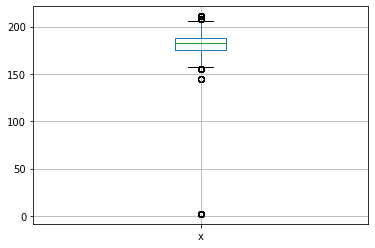

In [136]:
bp = pd.DataFrame.boxplot(df_tennis['winner_ht'], return_type='dict')

In [137]:
outliers_ht = [flier.get_ydata() for flier in bp["fliers"]][0]
outliers_ht = list(dict.fromkeys(outliers_ht))

In [138]:
w_names = df_tennis[df_tennis['winner_ht'].isin(outliers_ht)]['winner_name'].unique().tolist()

In [139]:
l_names = df_tennis[df_tennis['loser_ht'].isin(outliers_ht)]['loser_name'].unique().tolist()

In [140]:
w_names.sort() == l_names.sort() #True

True

In [141]:
df_tennis.loc[df_tennis['winner_name'].isin(w_names), 'winner_ht'] = np.nan
df_tennis.loc[df_tennis['loser_name'].isin(w_names), 'loser_ht'] = np.nan

In [142]:
male_names = df_players[df_players['sex']=='M']['whole_name'].tolist()
female_names = df_players[df_players['sex']=='F']['whole_name'].tolist()

In [143]:
#corrections using sex and ioc

In [144]:
df_ht = pd.concat([df_tennis[['winner_name', 'winner_ht', 'winner_ioc']].rename(columns={"winner_name": "name", "winner_ht": "ht", "winner_ioc": "ioc"}), df_tennis[['loser_name', 'loser_ht', 'loser_ioc']].rename(columns={"loser_name": "name", "loser_ht": "ht", "loser_ioc": "ioc"})]).drop_duplicates()

In [145]:
df_ht

,name,ht,ioc
0,Kei Nishikori,178.0,JPN
1,Daniil Medvedev,198.0,RUS
3,Jo Wilfried Tsonga,188.0,FRA
5,Jeremy Chardy,188.0,FRA
8,Alex De Minaur,183.0,AUS
...,...,...,...
185940,Chloe Henderson,NaN,USA
186074,Sara Errani,NaN,ITA
186077,unknown,NaN,RUS
186095,Marie Bouzkova,NaN,CZE


In [146]:
male_avg_ht = df_ht[(df_ht['name'].isin(male_names))].groupby('ioc').mean().reset_index()

In [147]:
for index, row in male_avg_ht[~male_avg_ht['ht'].isna()].iterrows():
    df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(male_names)) & (df_tennis['winner_ioc']==row['ioc']), 'winner_ht']=row['ht']
    df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(male_names)) & (df_tennis['loser_ioc']==row['ioc']), 'loser_ht']=row['ht']

In [148]:
female_avg_ht = df_ht[(df_ht['name'].isin(female_names))].groupby('ioc').mean().reset_index()

In [149]:
for index, row in female_avg_ht[~female_avg_ht['ht'].isna()].iterrows():
    df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(female_names)) & (df_tennis['winner_ioc']==row['ioc']), 'winner_ht']=row['ht']
    df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(female_names)) & (df_tennis['loser_ioc']==row['ioc']), 'loser_ht']=row['ht']

In [150]:
generic_avg_ht = df_ht[(df_ht['name'].isin(female_names))].groupby('ioc').mean().reset_index()

In [151]:
for index, row in generic_avg_ht[~generic_avg_ht['ht'].isna()].iterrows():
    df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_ioc']==row['ioc']), 'winner_ht']=row['ht']
    df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_ioc']==row['ioc']), 'loser_ht']=row['ht']

In [152]:
#correction using sex

In [153]:
male_mean = df_ht[df_ht['name'].isin(male_names)]['ht'].mean()

In [154]:
female_mean = df_ht[df_ht['name'].isin(female_names)]['ht'].mean()

In [155]:
df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(male_names)), 'winner_ht']=male_mean
df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(male_names)), 'loser_ht']=male_mean

In [156]:
df_tennis.loc[(df_tennis['winner_ht'].isna()) & (df_tennis['winner_name'].isin(female_names)), 'winner_ht']=female_mean
df_tennis.loc[(df_tennis['loser_ht'].isna()) & (df_tennis['loser_name'].isin(female_names)), 'loser_ht']=female_mean

In [157]:
df_players['height'] = -1

In [158]:
df_tennis['loser_ht'].fillna(value=df_ht['ht'].mean(), inplace=True) 

In [159]:
df_tennis['winner_ht'].fillna(value=df_ht['ht'].mean(), inplace=True) 

In [160]:
df_tennis['winner_ht'] = df_tennis['winner_ht'].map(round_2)
df_tennis['loser_ht'] = df_tennis['loser_ht'].map(round_2)

In [161]:
win_name_ht = dict(zip(df_tennis.winner_name, df_tennis.winner_ht))
loser_name_ht = dict(zip(df_tennis.loser_name, df_tennis.loser_ht))

names_ht_dict = win_name_ht.copy()
names_ht_dict.update(loser_name_ht)

In [162]:
for index, row in df_players.iterrows():
    if row['whole_name'] in names_ht_dict:
        df_players.loc[index, 'height'] = names_ht_dict[row['whole_name']]

### AGE

Age is expressed in days from birth. Where it is missing is calculated using a set value, calculating the date of birth and making the difference with the date of the tournament and recalculating the days

In [163]:
age_limit = 80
df_tennis.loc[df_tennis['winner_age'] > age_limit, 'winner_age'] = np.nan
df_tennis.loc[df_tennis['loser_age'] > age_limit, 'loser_age'] = np.nan

df_tennis_tmp = df_tennis.copy()

winner = df_tennis_tmp[df_tennis_tmp['winner_age'].isnull() & df_tennis_tmp['tourney_date'].notnull()]['winner_name'].drop_duplicates().tolist()
loser  = df_tennis_tmp[df_tennis_tmp['loser_age'].isnull() & df_tennis_tmp['tourney_date'].notnull()]['loser_name'].drop_duplicates().tolist()
merged = list(set(winner + loser))

for pl_name in merged:
    tourney_date = None
    pl_age = None
    
    ref = df_tennis_tmp[(df_tennis_tmp['winner_age'].notnull()) & (df_tennis_tmp['winner_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
    if len(ref) != 0:
        pl_age = ref.iloc[0]['winner_age']
        tourney_date = ref.iloc[0]['tourney_date']
    elif len(ref) != 0:
        ref = df_tennis_tmp[(df_tennis_tmp['loser_age'].notnull()) & (df_tennis_tmp['loser_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
        pl_age = ref.iloc[0]['loser_age']
        tourney_date = ref.iloc[0]['tourney_date']
    
    if pl_age is not None:
        str_tdate = str(tourney_date).replace(".0", "")
        tdate = datetime.strptime(str_tdate, "%Y%m%d")
        decimal_years = pl_age
        decimal_days = decimal_years * 365
        year = decimal_days//365
        tmp_days = decimal_days - (year*365)
        month = tmp_days//31
        days = tmp_days - (month * 31)
        birthdate = tdate - relativedelta(years=year, months=month, days=days)
        
        
        upd_loser = df_tennis_tmp[(df_tennis_tmp['loser_age'].isnull()) & (df_tennis_tmp['loser_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
        for index, row in upd_loser.iterrows():
            tmp_tourney_date = str(row['tourney_date']).replace(".0", "")
            tmp_tdate = datetime.strptime(str_tdate, "%Y%m%d")
            
            delta = tmp_tdate - birthdate
            days = delta.days/365
            #print(str(days))
            
            df_tennis.loc[
                (df_tennis['loser_age'].isnull()) & 
                (df_tennis['loser_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'loser_age'] = days
            
            df_tennis.loc[
                (df_tennis['winner_age'].isnull()) & 
                (df_tennis['winner_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'winner_age'] = days
            
        upd_winner = df_tennis_tmp[(df_tennis_tmp['winner_age'].isnull()) & (df_tennis_tmp['winner_name']==pl_name) & (df_tennis_tmp['tourney_date'].notnull())]
        for index, row in upd_winner.iterrows():
            tmp_tourney_date = str(row['tourney_date']).replace(".0", "")
            tmp_tdate = datetime.strptime(str_tdate, "%Y%m%d")
            
            delta = tmp_tdate - birthdate
            days = delta.days/365
            #print(str(days))
            
            df_tennis.loc[
                (df_tennis['loser_age'].isnull()) & 
                (df_tennis['loser_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'loser_age'] = days
            
            df_tennis.loc[
                (df_tennis['winner_age'].isnull()) & 
                (df_tennis['winner_name']==pl_name)  & 
                (df_tennis['tourney_date']==tourney_date), 
                'winner_age'] = days
        #break            

In [164]:
# test print: before was 2851
df_tennis[df_tennis['winner_age'].isnull()][['tourney_date','winner_name','winner_age','loser_name','loser_age']]

,tourney_date,winner_name,winner_age,loser_name,loser_age
322,20190114.0,Daniil Medvedev,NaN,David Goffin,28.104038
5890,20190914.0,Ari Fahresi,NaN,Ajeet Rai,20.640657
19065,20170724.0,Venia Yeung,NaN,Mihoki Miyahara,22.187543
21732,20170925.0,Nour Dib,NaN,Eva Kovaleva,15.162218
36444,20161212.0,Daria Lukyanova,NaN,Anca Craciun,16.837782
...,...,...,...,...,...
186114,20171113.0,unknown,NaN,Nina Stojanovic,21.289528
186117,20171113.0,unknown,NaN,Kai Lin Zhang,27.791923
186121,20171113.0,unknown,NaN,Vivian Heisen,NaN
186124,20171113.0,Veronika Kudermetova,NaN,Ingrid Neel,19.421918


In [165]:
# test print: 6536
df_tennis[df_tennis['loser_age'].isnull()][['tourney_date','winner_name','winner_age','loser_name','loser_age']]

,tourney_date,winner_name,winner_age,loser_name,loser_age
5883,20190914.0,Manuel Sanchez,28.676249,Adolfo Daniel Vallejo,NaN
6808,20180203.0,Manuel Sanchez,27.066393,Ignacio Garcia,NaN
6810,20180203.0,Manuel Sanchez,27.066393,Sebastian Arcila,NaN
6811,20180203.0,Luis Patino,24.314853,Ignacio Garcia,NaN
14665,20170612.0,Monika Kilnarova,17.678303,Paulina Bakaite,NaN
...,...,...,...,...,...
186119,20171113.0,Sabina Sharipova,23.192334,unknown,NaN
186120,20171113.0,unknown,21.289528,Na Lae Han,NaN
186121,20171113.0,unknown,NaN,Vivian Heisen,NaN
186122,20171113.0,Priscilla Hon,19.512663,Kwan Yau Ng,NaN


#### winner_age/loser_age, try to calculate birthdate
Convert age in birthdate, based on tourney_date

In [166]:
for index, row in df_players.iterrows():
      
    age_tdate = df_tennis[
            (df_tennis['winner_name']==row['whole_name']) & 
            (df_tennis['winner_age'].notnull()) & 
            (df_tennis['tourney_date'].notnull())][['winner_age','tourney_date']]
    if age_tdate is None:
        age_tdate = df_tennis[
            (df_tennis['loser_name']==row['whole_name']) & 
            (df_tennis['loser_age'].notnull()) & 
            (df_tennis['tourney_date'].notnull())][['loser_age','tourney_date']]
        
    if age_tdate.size > 0:
        str_tdate = str(age_tdate['tourney_date'].iloc[0]).replace(".0", "")
        
        tdate = datetime.strptime(str_tdate, "%Y%m%d")

        decimal_years = age_tdate['winner_age'].iloc[0]
        decimal_days = decimal_years * 365

        year = decimal_days//365

        tmp_days = decimal_days - (year*365)

        month = tmp_days//31
        days = tmp_days - (month * 31)


        birthdate = tdate - relativedelta(years=year, months=month, days=days)

        strbirthdate = birthdate.strftime("%d/%m/%Y")

        df_players.loc[df_players['whole_name'] == row['whole_name'], 'birthdate'] = strbirthdate

df_players.loc[df_players['birthdate'].isnull(),'birthdate']='unknown' 
df_players


,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,m_19,w_19,m_20,w_20,m_21,w_21,w_tourney,tot_minutes,height,birthdate
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,43,29,6,2,40,24,3,33023.911876,178.00,23/12/1989
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,80,59,38,28,50,40,14,38112.287152,198.00,15/02/1996
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,66,44,2,-1,9,1,7,21506.786448,188.00,20/04/1985
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,62,34,10,3,40,22,1,28833.134645,188.00,15/02/1987
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,57,38,23,13,38,21,6,29048.475556,183.00,20/02/1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,44.112350,173.77,unknown
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,73.520583,173.18,unknown
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,55.140437,173.18,unknown
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,128.661020,173.18,unknown


In [167]:
df_tennis.loc[df_tennis['loser_age'].isnull(),'loser_age'] = -1 
df_tennis.loc[df_tennis['winner_age'].isnull(),'winner_age'] = -1
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,m_19,w_19,m_20,w_20,m_21,w_21,w_tourney,tot_minutes,height,birthdate
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,43,29,6,2,40,24,3,33023.911876,178.00,23/12/1989
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,80,59,38,28,50,40,14,38112.287152,198.00,15/02/1996
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,66,44,2,-1,9,1,7,21506.786448,188.00,20/04/1985
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,62,34,10,3,40,22,1,28833.134645,188.00,15/02/1987
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,57,38,23,13,38,21,6,29048.475556,183.00,20/02/1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,44.112350,173.77,unknown
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,73.520583,173.18,unknown
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,55.140437,173.18,unknown
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,1,-1,-1,-1,0,128.661020,173.18,unknown


#### w_svpt, l_svpt, w_1stIn, l_1stIn, w_1stWon, l_1stWon, w_2ndWon, l_2ndWon, w_df, l_df

Since these values can't be calculated, we substitute null values with a default value. <br>
In the player dataset we calculate for each player: the number of first serves made and won, the number of second serves won and the nuber of double fault.

In [168]:
w_1stIn_dict = df_tennis[~df_tennis['w_1stIn'].isnull()].groupby('winner_name')['w_1stIn'].apply(list).to_dict()   
for key in w_1stIn_dict.keys():
    w_1stIn_dict[key]= sum(w_1stIn_dict[key])
    
l_1stIn_dict = df_tennis[~df_tennis['l_1stIn'].isnull()].groupby('loser_name')['l_1stIn'].apply(list).to_dict()   
for key in l_1stIn_dict.keys():
    l_1stIn_dict[key]= sum(l_1stIn_dict[key])
    
w_1stwin_dict = df_tennis[~df_tennis['w_1stWon'].isnull()].groupby('winner_name')['w_1stWon'].apply(list).to_dict()   
for key in w_1stwin_dict.keys():
    w_1stwin_dict[key]= sum(w_1stwin_dict[key])
    
l_1stwin_dict = df_tennis[~df_tennis['l_1stWon'].isnull()].groupby('loser_name')['l_1stWon'].apply(list).to_dict()   
for key in l_1stwin_dict.keys():
    l_1stwin_dict[key]= sum(l_1stwin_dict[key])

In [169]:
#won first services on the total fisrt services not on the total served points
df_players['sv1st'] = 0
df_players['sv1st_win'] = 0

In [170]:
for index, row in df_players.iterrows():
    name = row['whole_name']
    
    total_first = 0
    won_first = 0
    
    if name in w_1stIn_dict.keys():
        total_first += w_1stIn_dict[name]
        won_first += w_1stwin_dict[name]
    if name in l_1stIn_dict.keys():
        total_first += l_1stIn_dict[name]
        won_first += l_1stwin_dict[name]
        
    if total_first!=0:
        df_players.loc[index, 'sv1st'] = total_first
        df_players.loc[index, 'sv1st_win'] = won_first

In [171]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,m_20,w_20,m_21,w_21,w_tourney,tot_minutes,height,birthdate,sv1st,sv1st_win
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,6,2,40,24,3,33023.911876,178.00,23/12/1989,14032,9825
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,38,28,50,40,14,38112.287152,198.00,15/02/1996,16455,12334
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,2,-1,9,1,7,21506.786448,188.00,20/04/1985,9433,7474
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,10,3,40,22,1,28833.134645,188.00,15/02/1987,13288,9835
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,23,13,38,21,6,29048.475556,183.00,20/02/1999,12382,8699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,44.112350,173.77,unknown,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,73.520583,173.18,unknown,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,55.140437,173.18,unknown,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,1,-1,-1,-1,0,128.661020,173.18,unknown,0,0


In [172]:
w_2ndwin_dict = df_tennis[~df_tennis['w_2ndWon'].isnull()].groupby('winner_name')['w_2ndWon'].apply(list).to_dict()   
for key in w_2ndwin_dict.keys():
    w_2ndwin_dict[key]= sum(w_2ndwin_dict[key])
    
l_2ndwin_dict = df_tennis[~df_tennis['l_2ndWon'].isnull()].groupby('loser_name')['l_2ndWon'].apply(list).to_dict()   
for key in l_2ndwin_dict.keys():
    l_2ndwin_dict[key]= sum(l_2ndwin_dict[key])

In [173]:
#won second services 
df_players['sv2nd_win'] = 0

In [174]:
for index, row in df_players.iterrows():
    name = row['whole_name']
    
    won = 0
    
    if name in w_2ndwin_dict.keys():
        won += w_2ndwin_dict[name]
    if name in l_2ndwin_dict.keys():
        won += l_2ndwin_dict[name]
        
    df_players.loc[index, 'sv2nd_win'] = won

In [175]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_20,m_21,w_21,w_tourney,tot_minutes,height,birthdate,sv1st,sv1st_win,sv2nd_win
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,2,40,24,3,33023.911876,178.00,23/12/1989,14032,9825,4689
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,28,50,40,14,38112.287152,198.00,15/02/1996,16455,12334,5789
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,-1,9,1,7,21506.786448,188.00,20/04/1985,9433,7474,3168
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,3,40,22,1,28833.134645,188.00,15/02/1987,13288,9835,3998
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,13,38,21,6,29048.475556,183.00,20/02/1999,12382,8699,4431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,-1,-1,0,44.112350,173.77,unknown,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,-1,-1,0,73.520583,173.18,unknown,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,-1,-1,0,55.140437,173.18,unknown,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,-1,-1,0,128.661020,173.18,unknown,0,0,0


In [176]:
w_df_dict = df_tennis[(~df_tennis['w_df'].isnull()) & (~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_df'].apply(list).to_dict()   
for key in w_df_dict.keys():
    w_df_dict[key]= sum(w_df_dict[key])
    
l_df_dict = df_tennis[(~df_tennis['l_df'].isnull()) & (~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_df'].apply(list).to_dict()   
for key in l_df_dict.keys():
    l_df_dict[key]= sum(l_df_dict[key])
    
w_sv_dict = df_tennis[(~df_tennis['w_df'].isnull()) & (~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_svpt'].apply(list).to_dict()   
for key in w_sv_dict.keys():
    w_sv_dict[key]= sum(w_sv_dict[key])
    
l_sv_dict = df_tennis[(~df_tennis['l_df'].isnull()) & (~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_svpt'].apply(list).to_dict()   
for key in l_sv_dict.keys():
    l_sv_dict[key]= sum(l_sv_dict[key])

In [177]:
#considered matches
w_match = df_tennis[(~df_tennis['w_df'].isnull()) & (~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_df'].agg('count').to_dict()
l_match = df_tennis[(~df_tennis['l_df'].isnull()) & (~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_df'].agg('count').to_dict()

In [178]:
df_players['df'] = 0

In [179]:
for index, row in df_players.iterrows():
    name = row['whole_name']
    
    total_points = 0
    df = 0
    if name in w_df_dict.keys():
        total_points += w_sv_dict[name]
        df += w_df_dict[name]
    if name in l_df_dict.keys():
        total_points += l_sv_dict[name]
        df += l_df_dict[name]
        
    df_players.loc[index, 'df'] = df

In [180]:
df_players[['whole_name', 'sv1st_win', 'df']]

,whole_name,sv1st_win,df
0,Kei Nishikori,9825,644
1,Daniil Medvedev,12334,1205
2,Jo Wilfried Tsonga,7474,504
3,Jeremy Chardy,9835,1119
4,Alex De Minaur,8699,742
...,...,...,...
10098,Dilara Sultanova,0,0
10099,Madeleine Jessup,0,0
10100,Katie Codd,0,0
10101,Amy Huang,0,0


In [181]:
df_tennis['w_df'].fillna(value=-1, inplace=True) 

In [182]:
df_tennis['l_df'].fillna(value=-1, inplace=True) 

In [183]:
df_tennis['w_1stIn'].fillna(value=-1, inplace=True) 

In [184]:
df_tennis['l_1stIn'].fillna(value=-1, inplace=True) 

In [185]:
df_tennis['w_1stWon'].fillna(value=-1, inplace=True) 

In [186]:
df_tennis['l_1stWon'].fillna(value=-1, inplace=True) 

In [187]:
df_tennis['w_2ndWon'].fillna(value=-1, inplace=True) 

In [188]:
df_tennis['l_2ndWon'].fillna(value=-1, inplace=True) 

**Service point and ace statistics and cleaning**

In [189]:
w_svpt = df_tennis[(~df_tennis['w_svpt'].isnull())].groupby('winner_name')['w_svpt'].agg('sum').to_dict()
l_svpt = df_tennis[(~df_tennis['l_svpt'].isnull())].groupby('loser_name')['l_svpt'].agg('sum').to_dict()

#merging players svpts
for l_key in l_svpt.keys():
    if(l_key in w_svpt.keys()):
        l_svpt[l_key]+=w_svpt[l_key]
for w_key in w_svpt.keys():
    if(w_key not in l_svpt.keys()):
        l_svpt[w_key]= w_svpt[w_key]

merged_svp = l_svpt

In [190]:
df_tennis['w_svpt'].fillna(value=-1, inplace=True) 
df_tennis.loc[df_tennis['l_svpt'] > 300, 'w_svpt'] = -1

In [191]:
df_tennis['l_svpt'].fillna(value=-1, inplace=True) 
df_tennis.loc[df_tennis['l_svpt'] > 300, 'l_svpt'] = -1

#### w_ace

In the section its computed the total amount of ace performed by each player and added this information to the player dataset.

In [192]:
w_ace = df_tennis[(~df_tennis['w_ace'].isnull()) & (df_tennis['w_svpt'] != -1)].groupby('winner_name')['w_ace'].agg('sum').to_dict()
l_ace = df_tennis[(~df_tennis['l_ace'].isnull()) & (df_tennis['l_svpt'] != -1)].groupby('loser_name')['l_ace'].agg('sum').to_dict()

#merging players aces
for l_key in l_ace.keys():
    if(l_key in w_ace.keys()):
        l_ace[l_key]+=w_ace[l_key]
for w_key in w_ace.keys():
    if(w_key not in l_ace.keys()):
        l_ace[w_key]= w_ace[w_key]
merged_ace = l_ace
        
for name in merged_ace.keys():
    if (merged_ace[name]):
        svpt = merged_svp[name]
        ace = merged_ace[name]
        df_players.loc[df_players['whole_name'] == name, 'ace'] = ace
df_players.loc[df_players['ace'].isnull(), 'ace'] = 0

In [193]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_21,w_tourney,tot_minutes,height,birthdate,sv1st,sv1st_win,sv2nd_win,df,ace
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,24,3,33023.911876,178.00,23/12/1989,14032,9825,4689,644,872.0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,40,14,38112.287152,198.00,15/02/1996,16455,12334,5789,1205,2854.0
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,1,7,21506.786448,188.00,20/04/1985,9433,7474,3168,504,1917.0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,22,1,28833.134645,188.00,15/02/1987,13288,9835,3998,1119,2227.0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,21,6,29048.475556,183.00,20/02/1999,12382,8699,4431,742,968.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,-1,0,44.112350,173.77,unknown,0,0,0,0,0.0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,-1,0,73.520583,173.18,unknown,0,0,0,0,0.0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,-1,0,55.140437,173.18,unknown,0,0,0,0,0.0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,-1,0,128.661020,173.18,unknown,0,0,0,0,0.0


In [194]:
df_tennis['w_ace'].fillna(value=-1, inplace=True)

In [195]:
df_tennis['l_ace'].fillna(value=-1, inplace=True)

#### w_SvGms and l_SvGms

At the end of a set without tie-break, to establish which is in the next set the player that should serve: divide by 2 the sum of all the games played in the set. If the remainder of the division is 0 (even number of games played), the player that serves is the same of the first game of set, otherwise is the other one.

If the set ends with a tie-break (odd number of games already played), the player that serves the next set is not the same of the first game of the set just finished (i.e. the player that serve first the tie-break)

Following these rules we calculate if the number of service games of winner and loser can be valid. If it is not valid we try to correct it looking these rules using the score value. If we cannot calculate the correct value we correct using a default value (-1).

In [196]:
#correction of errors in case not nulls
for index,row in df_tennis[(~df_tennis['l_SvGms'].isnull()) & (~df_tennis['w_SvGms'].isnull()) & (df_tennis['score']!="")].iterrows():
    
    if len(sets)==1 and (Walkover(sets[0]) or Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0])):
        df_tennis.loc[index, 'w_SvGms']=0
        df_tennis.loc[index, 'l_SvGms']=0
        continue
    
    if not validity_match(row['score'].split(), row['best_of']):
        continue
    
    result = count_service_games(row['score'])
    x = result[0]
    y = result[1]
    if x == -1:
        continue
    
    if not((row['w_SvGms']==x and row['l_SvGms']==y) or (row['w_SvGms']==y and row['l_SvGms']==x)): 
        if row['w_SvGms']==x:
            df_tennis.loc[index, 'l_SvGms']=y
        elif row['w_SvGms']==y:
            df_tennis.loc[index, 'l_SvGms']=x
        elif row['l_SvGms']==x:
            df_tennis.loc[index, 'w_SvGms']=y
        elif row['l_SvGms']==y:
            df_tennis.loc[index, 'w_SvGms']=x
        else:
            df_tennis.loc[index, 'w_SvGms']=x
            df_tennis.loc[index, 'l_SvGms']=y
        

In [197]:
#correction of errors in case of nulls
for index,row in df_tennis[(df_tennis['score']!="") & (df_tennis['l_SvGms'].isnull())].iterrows():
    
    sets = row['score'].split()
    
    if len(sets)==1 and (Walkover(sets[0]) or Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0])):
        df_tennis.loc[index, 'w_SvGms']=0
        df_tennis.loc[index, 'l_SvGms']=0
        continue
    
    if not validity_match(sets, row['best_of']):
        continue
    
    result = count_service_games(row['score'])
    x = result[0]
    y = result[1]
    if x == -1:
        continue
    
    winner = math.isnan(float(row['w_SvGms']))
    
    if not winner:
        if row['w_SvGms']==x:
            df_tennis.loc[index, 'l_SvGms']=y
        elif row['w_SvGms']==y:
            df_tennis.loc[index, 'l_SvGms']=x
        else:
            df_tennis.loc[index, 'w_SvGms']=x
            df_tennis.loc[index, 'l_SvGms']=y
    else:
        df_tennis.loc[index, 'w_SvGms']=x
        df_tennis.loc[index, 'l_SvGms']=y

In [198]:
#correction of errors in case of nulls
for index,row in df_tennis[(df_tennis['score']!="") & (df_tennis['w_SvGms'].isnull())].iterrows():
    
    if len(sets)==1 and (Walkover(sets[0]) or Retirement(sets[0]) or Default(sets[0]) or Bye(sets[0])):
        df_tennis.loc[index, 'w_SvGms']=0
        df_tennis.loc[index, 'l_SvGms']=0
        continue
    
    if not validity_match(row['score'].split(), row['best_of']):
        continue
    
    result = count_service_games(row['score'])
    x = result[0]
    y = result[1]
    if x == -1:
        continue
    
    loser = math.isnan(float(row['l_SvGms']))
    
    if not loser:
        if row['l_SvGms']==x:
            df_tennis.loc[index, 'w_SvGms']=y
        elif row['l_SvGms']==y:
            df_tennis.loc[index, 'w_SvGms']=x
        else:
            df_tennis.loc[index, 'w_SvGms']=x
            df_tennis.loc[index, 'l_SvGms']=y
    else:
        df_tennis.loc[index, 'w_SvGms']=x
        df_tennis.loc[index, 'l_SvGms']=y

In [199]:
df_tennis['l_SvGms'].fillna(value=-1, inplace=True)
df_tennis['w_SvGms'].fillna(value=-1, inplace=True)

**Breakpoint statistics and cleaning**

In the section its computed the total amount of breakpoints saved by each player and added this information to the player dataset.

In [200]:
df_tennis[df_tennis['w_bpFaced'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
108,2019-0451,Doha,Hard,32.0,A,20181231.0,288.0,106065.0,U,Marco Cecchinato,...,-1.0,0.0,NaN,NaN,20.0,1819.0,58.0,860.0,2923.0,550943.19
262,2019-M001,Sydney,Hard,32.0,P,20190107.0,290.0,202428.0,U,Kiki Bertens,...,-1.0,0.0,NaN,NaN,9.0,4360.0,18.0,2910.0,3258.0,567644.24
681,2019-580,Australian Open,Hard,128.0,G,20190114.0,112.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,NaN,106.0,571.0,175.0,335.0,15583.0,2781000.18
730,2019-580,Australian Open,Hard,128.0,G,20190114.0,161.0,202424.0,U,Conny Perrin,...,-1.0,-1.0,NaN,NaN,150.0,385.0,178.0,325.0,15583.0,2781000.18
768,2019-580,Australian Open,Hard,128.0,G,20190114.0,199.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,NaN,106.0,571.0,136.0,438.0,15583.0,2781000.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186118,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,-1.0,U,unknown,...,-1.0,8.0,NaN,11.0,0.0,228.0,0.0,204.0,2722.0,638954.72
186120,unknown,Taipei,Hard,32.0,I,20171113.0,-1.0,-1.0,U,unknown,...,9.0,11.0,2.0,NaN,230.0,0.0,250.0,221.0,2722.0,443410.22
186122,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,211880.0,U,Priscilla Hon,...,-1.0,8.0,8.0,NaN,0.0,0.0,0.0,8.0,2722.0,638954.72
186123,unknown,Taipei,Hard,32.0,I,20171113.0,250.0,-1.0,U,unknown,...,-1.0,13.0,7.0,11.0,0.0,322.0,280.0,183.0,2722.0,443410.22


In [201]:
w_bpF = df_tennis[(~df_tennis['w_bpFaced'].isnull()) & (df_tennis['w_bpFaced'] > 0)].groupby('winner_name')['w_bpFaced'].agg('sum').to_dict()
l_bpF = df_tennis[(~df_tennis['l_bpFaced'].isnull()) & (df_tennis['w_bpFaced'] > 0)].groupby('loser_name')['l_bpFaced'].agg('sum').to_dict()

#merging players bpFs
for l_key in l_bpF.keys():
    if(l_key in w_bpF.keys()):
        l_bpF[l_key]+=w_bpF[l_key]
for w_key in w_bpF.keys():
    if(w_key not in l_bpF.keys()):
        l_bpF[w_key]= w_bpF[w_key]
merged_bpF = l_bpF

In [202]:
df_tennis['w_bpFaced'].fillna(value=-1, inplace=True) 

In [203]:
df_tennis['l_bpFaced'].fillna(value=-1, inplace=True) 

In [204]:
df_tennis[df_tennis['w_bpSaved'].isnull()]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_name,...,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_spectators,tourney_revenue
108,2019-0451,Doha,Hard,32.0,A,20181231.0,288.0,106065.0,U,Marco Cecchinato,...,-1.0,0.0,NaN,-1.0,20.0,1819.0,58.0,860.0,2923.0,550943.19
262,2019-M001,Sydney,Hard,32.0,P,20190107.0,290.0,202428.0,U,Kiki Bertens,...,-1.0,0.0,NaN,-1.0,9.0,4360.0,18.0,2910.0,3258.0,567644.24
681,2019-580,Australian Open,Hard,128.0,G,20190114.0,112.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,-1.0,106.0,571.0,175.0,335.0,15583.0,2781000.18
730,2019-580,Australian Open,Hard,128.0,G,20190114.0,161.0,202424.0,U,Conny Perrin,...,-1.0,-1.0,NaN,-1.0,150.0,385.0,178.0,325.0,15583.0,2781000.18
768,2019-580,Australian Open,Hard,128.0,G,20190114.0,199.0,215370.0,U,Bianca Andreescu,...,-1.0,-1.0,NaN,-1.0,106.0,571.0,136.0,438.0,15583.0,2781000.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186112,unknown,Taipei,Hard,32.0,I,20171113.0,251.0,206368.0,U,Veronika Kudermetova,...,7.0,-1.0,NaN,-1.0,0.0,0.0,0.0,27.0,3535.0,443410.22
186116,unknown,Taipei,Hard,32.0,I,20171113.0,-1.0,214562.0,WC,Ingrid Neel,...,21.0,16.0,NaN,22.0,704.0,27.0,150.0,0.0,3535.0,638954.72
186121,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,-1.0,U,unknown,...,15.0,8.0,8.0,-1.0,176.0,335.0,0.0,131.0,3535.0,638954.72
186122,unknown,Taipei,Hard,32.0,C,20171113.0,-1.0,211880.0,U,Priscilla Hon,...,-1.0,8.0,8.0,-1.0,0.0,0.0,0.0,8.0,2722.0,638954.72


In [205]:
w_bpS = df_tennis[(~df_tennis['w_bpSaved'].isnull()) & (df_tennis['w_bpFaced'] != -1)].groupby('winner_name')['w_bpSaved'].agg('sum').to_dict()
l_bpS = df_tennis[(~df_tennis['l_bpSaved'].isnull()) & (df_tennis['l_bpFaced'] != -1)].groupby('loser_name')['l_bpSaved'].agg('sum').to_dict()

#merging players bpSaveds
for l_key in l_bpS.keys():
    if(l_key in w_bpS.keys()):
        l_bpS[l_key]+=w_bpS[l_key]
        
for w_key in w_bpS.keys():
    if(w_key not in l_bpS.keys()):
        l_bpS[w_key]= w_bpS[w_key]
merged_bpS = l_bpS
              
for name in merged_bpS.keys():
    if (name in l_bpF.keys()):
        bpF = merged_bpF[name]
        bpS = merged_bpS[name]
        df_players.loc[df_players['whole_name'] == name, 'bpS'] = bpS
df_players.loc[df_players['bpS'].isnull(), 'bpS'] = 0

In [206]:
df_tennis['w_bpSaved'].fillna(value=-1, inplace=True) 

In [207]:
df_tennis['l_bpSaved'].fillna(value=-1, inplace=True) 

In [208]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_tourney,tot_minutes,height,birthdate,sv1st,sv1st_win,sv2nd_win,df,ace,bpS
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,3,33023.911876,178.00,23/12/1989,14032,9825,4689,644,872.0,1154.0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,14,38112.287152,198.00,15/02/1996,16455,12334,5789,1205,2854.0,1305.0
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,7,21506.786448,188.00,20/04/1985,9433,7474,3168,504,1917.0,636.0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,1,28833.134645,188.00,15/02/1987,13288,9835,3998,1119,2227.0,1049.0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,6,29048.475556,183.00,20/02/1999,12382,8699,4431,742,968.0,1051.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,0,44.112350,173.77,unknown,0,0,0,0,0.0,0.0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,0,73.520583,173.18,unknown,0,0,0,0,0.0,0.0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,0,55.140437,173.18,unknown,0,0,0,0,0.0,0.0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,0,128.661020,173.18,unknown,0,0,0,0,0.0,0.0


#### count the games played, won and lost

In [209]:
count_dict_w = df_tennis['winner_name'].value_counts().sort_index().to_dict()
count_dict_l = df_tennis['loser_name'].value_counts().sort_index().to_dict()


df_players['wmatch'] = 0
df_players['lmatch'] = 0
df_players['nmatch'] = 0

for index,row in df_players.iterrows():
    name = row['whole_name']
    w = count_dict_w.get(name)
    l = count_dict_l.get(name)
    if w is None:
        w = 0
    if l is None:
        l = 0
    tot = w + l
    df_players.loc[df_players['whole_name'] == name, 'wmatch'] = w
    df_players.loc[df_players['whole_name'] == name, 'lmatch'] = l
    df_players.loc[df_players['whole_name'] == name, 'nmatch'] = tot


In [210]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,birthdate,sv1st,sv1st_win,sv2nd_win,df,ace,bpS,wmatch,lmatch,nmatch
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,23/12/1989,14032,9825,4689,644,872.0,1154.0,191,92,283
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,15/02/1996,16455,12334,5789,1205,2854.0,1305.0,267,115,382
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,20/04/1985,9433,7474,3168,504,1917.0,636.0,125,72,197
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,15/02/1987,13288,9835,3998,1119,2227.0,1049.0,149,131,280
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,20/02/1999,12382,8699,4431,742,968.0,1051.0,164,108,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,unknown,0,0,0,0,0.0,0.0,0,1,1
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,unknown,0,0,0,0,0.0,0.0,0,1,1
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,unknown,0,0,0,0,0.0,0.0,0,1,1
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,unknown,0,0,0,0,0.0,0.0,0,1,1


In [211]:
df_players.loc[df_players['nmatch']==1]
df_players.loc[df_players['nmatch']!=(df_players['best_of_5_match'] + df_players['best_of_3_match'])]

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,birthdate,sv1st,sv1st_win,sv2nd_win,df,ace,bpS,wmatch,lmatch,nmatch
2869,Takuto Niki,M,JPN,105026.0,U,304,756,62,0,27,...,13/10/1987,2665,1854,818,142,311.0,231.0,28,36,64
2967,Andrei Vasilevski,M,BLR,105781.0,R,591,939,41,0,17,...,03/06/1991,1700,1273,635,151,336.0,147.0,18,25,43
3341,Steven De Waard,M,AUS,122059.0,R,723,1320,27,0,9,...,08/05/1991,1166,791,366,110,102.0,108.0,10,19,29
4473,Lyubov Kostenko,F,UKR,221371.0,R,998,1144,69,0,34,...,30/03/2003,0,0,0,0,0.0,0.0,35,36,71
4547,Sophia Fry,F,AUS,221862.0,R,0,0,17,0,4,...,02/08/2000,0,0,0,0,0.0,0.0,5,14,19
4833,Liisa Varul,F,TUR,224486.0,U,0,0,5,0,1,...,unknown,0,0,0,0,0.0,0.0,2,5,7


#### count the win and lose in surfaces

In [212]:
dict_surf = df_tennis.groupby(['winner_name'])['surface'].value_counts().to_dict()
surface_type_array = df_tennis['surface'].unique()

for index,row in df_players.iterrows():
    name = row['whole_name']
    for surface in surface_type_array:
        win_in_surface = dict_surf.get((name, surface))
        if win_in_surface is None:
            win_in_surface = 0              
        df_players.loc[df_players['whole_name'] == name, "w_surface_" + surface] = str(win_in_surface)
    #if index == 100:
    #    break
# remove unknown w/l columns
df_players.drop(['w_surface_unknown'], axis=1)
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,ace,bpS,wmatch,lmatch,nmatch,w_surface_Hard,w_surface_Clay,w_surface_Grass,w_surface_Carpet,w_surface_unknown
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,872.0,1154.0,191,92,283,117,56,18,0,0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,2854.0,1305.0,267,115,382,205,27,35,0,0
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,1917.0,636.0,125,72,197,91,23,11,0,0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,2227.0,1049.0,149,131,280,89,40,20,0,0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,968.0,1051.0,164,108,272,117,16,31,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,0.0,0.0,0,1,1,0,0,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,0.0,0.0,0,1,1,0,0,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,0.0,0.0,0,1,1,0,0,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,0.0,0.0,0,1,1,0,0,0,0,0


In [213]:
dict_surf = df_tennis.groupby(['loser_name'])['surface'].value_counts().to_dict()
surface_type_array = df_tennis['surface'].unique()

for index,row in df_players.iterrows():
    name = row['whole_name']
    for surface in surface_type_array:
        win_in_surface = dict_surf.get((name, surface))
        if win_in_surface is None:
            win_in_surface = 0              
        df_players.loc[df_players['whole_name'] == name, "l_surface_" + surface] = str(win_in_surface)
    #if index == 100:
    #    break
df_players.drop(['l_surface_unknown'], axis=1)
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_surface_Hard,w_surface_Clay,w_surface_Grass,w_surface_Carpet,w_surface_unknown,l_surface_Hard,l_surface_Clay,l_surface_Grass,l_surface_Carpet,l_surface_unknown
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,117,56,18,0,0,55,28,9,0,0
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,205,27,35,0,0,73,26,16,0,0
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,91,23,11,0,0,46,18,8,0,0
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,89,40,20,0,0,77,39,15,0,0
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,117,16,31,0,0,68,25,15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [214]:
played_touney_winner = df_tennis.groupby('winner_name')['tourney_id'].apply(list).to_dict()  
played_touney_loser = df_tennis.groupby('loser_name')['tourney_id'].apply(list).to_dict()  

In [215]:
for key in played_touney_winner.keys():
    if key in played_touney_loser.keys():
        played_touney_loser[key] = list(dict.fromkeys(played_touney_winner[key]+played_touney_loser[key]))
    else:
        played_touney_loser[key] = played_touney_winner[key]
        

In [216]:
played_touney_loser

{'Aada Inna': ['2021-W-ITF-FIN-01A-2021'],
 'Aalisha Alexis': ['2019-W-ITF-TTO-01A-2019', '2019-W-ITF-TTO-02A-2019'],
 'Aaliya Ebrahim': ['2019-W-ITF-EGY-20A-2019',
  '2019-W-ITF-EGY-22A-2019',
  '2019-W-ITF-EGY-17A-2019',
  '2019-W-ITF-EGY-18A-2019',
  '2019-W-ITF-EGY-21A-2019',
  '2019-W-ITF-IND-06A-2019',
  '2020-W-ITF-THA-01A-2020'],
 'Aaliyah Hohmann': ['2021-W-ITF-TUN-29A-2021', '2021-W-ITF-TUN-30A-2021'],
 'Aalyka Ebrahim': ['2019-W-ITF-EGY-17A-2019',
  '2019-W-ITF-EGY-18A-2019',
  '2019-W-ITF-EGY-20A-2019',
  '2019-W-ITF-EGY-21A-2019'],
 'Aanisha Rahul Shewate': ['2021-W-ITF-IND-02A-2021'],
 'Aanisha Rahul Shewate Aanisha Rahul Shewate': ['2019-W-ITF-IND-05A-2019'],
 'Aanu Ayegbusi': ['2019-W-ITF-NGR-01A-2019',
  '2019-W-ITF-NGR-02A-2019',
  '2018-W-WITF-NGR-02A-2018'],
 'Aareyalee Amrutsinh Chavan': ['2016-W-C10-IND-01A-2016'],
 'Aaro Pollanen': ['2017-0221'],
 'Aaron Addison': ['2016-7203',
  '2016-6865',
  '2016-7393',
  '2016-7586',
  '2020-7841',
  '2019-6865',
  '2019-739

In [217]:
df_players['n_tourney'] = 0

In [218]:
for index,row in df_players.iterrows():
    name = row['whole_name']
    df_players.loc[index, 'n_tourney'] = len(played_touney_loser[name])

In [219]:
df_players

,whole_name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_surface_Clay,w_surface_Grass,w_surface_Carpet,w_surface_unknown,l_surface_Hard,l_surface_Clay,l_surface_Grass,l_surface_Carpet,l_surface_unknown,n_tourney
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,56,18,0,0,55,28,9,0,0,91
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,27,35,0,0,73,26,16,0,0,129
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,23,11,0,0,46,18,8,0,0,82
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,40,20,0,0,77,39,15,0,0,133
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,16,31,0,0,68,25,15,0,0,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [220]:
#rename column of name of players
df_players.rename(columns={"whole_name": "name"})

,name,sex,ioc,id,hand,best_rank,best_rank_points,best_of_3_match,best_of_5_match,best_of_3_wins,...,w_surface_Clay,w_surface_Grass,w_surface_Carpet,w_surface_unknown,l_surface_Hard,l_surface_Clay,l_surface_Grass,l_surface_Carpet,l_surface_unknown,n_tourney
0,Kei Nishikori,M,JPN,105453.0,R,4,5010,208,75,135,...,56,18,0,0,55,28,9,0,0,91
1,Daniil Medvedev,M,RUS,106421.0,R,2,10620,324,58,229,...,27,35,0,0,73,26,16,0,0,129
2,Jo Wilfried Tsonga,M,FRA,104542.0,R,7,3480,148,49,95,...,23,11,0,0,46,18,8,0,0,82
3,Jeremy Chardy,M,FRA,104871.0,R,28,1265,242,38,135,...,40,20,0,0,77,39,15,0,0,133
4,Alex De Minaur,M,AUS,200282.0,R,15,2690,234,38,145,...,16,31,0,0,68,25,15,0,0,114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10098,Dilara Sultanova,F,TKM,223315.0,U,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
10099,Madeleine Jessup,F,USA,223075.0,U,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
10100,Katie Codd,F,USA,223216.0,U,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
10101,Amy Huang,F,USA,223217.0,U,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [221]:
#save on file
file_name = '..' + os.path.sep + "dataset" + os.path.sep + 'players.csv'
df_players.to_csv(path_or_buf=file_name)

### Correlation

Here we analyze the correlation of the dataset of tennis after all the changes we made.  To do this we do not consider the default values we have introduced because they influence the correlation.

In [222]:
df_tennis.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size             float64
tourney_level          object
tourney_date           object
match_num             float64
winner_id             float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id              float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of               float64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms               float64
w_bpSaved             float64
w_bpFaced 

In [223]:
df_numeric = df_tennis[['draw_size','minutes','w_ace','w_df','w_svpt','w_1stIn', 'w_1stWon', 'w_2ndWon', 
                        'w_SvGms', 'winner_rank', 'winner_rank_points', 'w_bpSaved',  'w_bpFaced','l_ace',
                        'l_df','l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'loser_rank', 
                        'loser_rank_points', 'l_bpSaved',  'l_bpFaced', 'tourney_spectators', 'tourney_revenue',
                       'winner_ht','winner_age','loser_ht','loser_age']]
df_numeric

,draw_size,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,winner_rank,...,loser_rank,loser_rank_points,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue,winner_ht,winner_age,loser_ht,loser_age
0,32.0,124.000000,3.0,3.0,77.0,44.0,31.0,17.0,13.0,9.0,...,16.0,1977.0,10.0,15.0,3928.0,742618.69,178.00,29.021918,198.00,22.885695
1,32.0,82.000000,10.0,1.0,52.0,33.0,28.0,14.0,10.0,16.0,...,239.0,200.0,10.0,13.0,3928.0,742618.69,198.00,22.885695,188.00,33.705681
2,32.0,66.000000,2.0,2.0,47.0,33.0,26.0,9.0,8.0,9.0,...,40.0,1050.0,1.0,5.0,3928.0,742618.69,178.00,29.004791,188.00,31.882272
3,32.0,106.000000,12.0,2.0,68.0,43.0,34.0,15.0,11.0,239.0,...,31.0,1298.0,4.0,6.0,3928.0,742618.69,188.00,33.705681,183.00,19.868583
4,32.0,129.000000,12.0,3.0,105.0,68.0,48.0,25.0,16.0,16.0,...,18.0,1855.0,2.0,4.0,3928.0,742618.69,198.00,22.885695,196.00,28.010951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186123,32.0,95.576758,-1.0,1.0,-1.0,49.0,38.0,16.0,13.0,0.0,...,280.0,183.0,7.0,11.0,2722.0,443410.22,177.25,26.206708,165.60,26.904860
186124,32.0,71.000000,10.0,8.0,63.0,-1.0,32.0,-1.0,10.0,255.0,...,704.0,0.0,-1.0,-1.0,2722.0,443410.22,175.00,-1.000000,173.18,19.421918
186125,32.0,70.000000,-1.0,2.0,55.0,-1.0,-1.0,-1.0,-1.0,0.0,...,0.0,0.0,-1.0,11.0,2722.0,443410.22,173.33,26.642026,173.77,-1.000000
186126,32.0,115.000000,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,12.0,176.0,...,0.0,0.0,3.0,-1.0,3535.0,443410.22,170.00,-1.000000,176.20,19.898630


<AxesSubplot:>

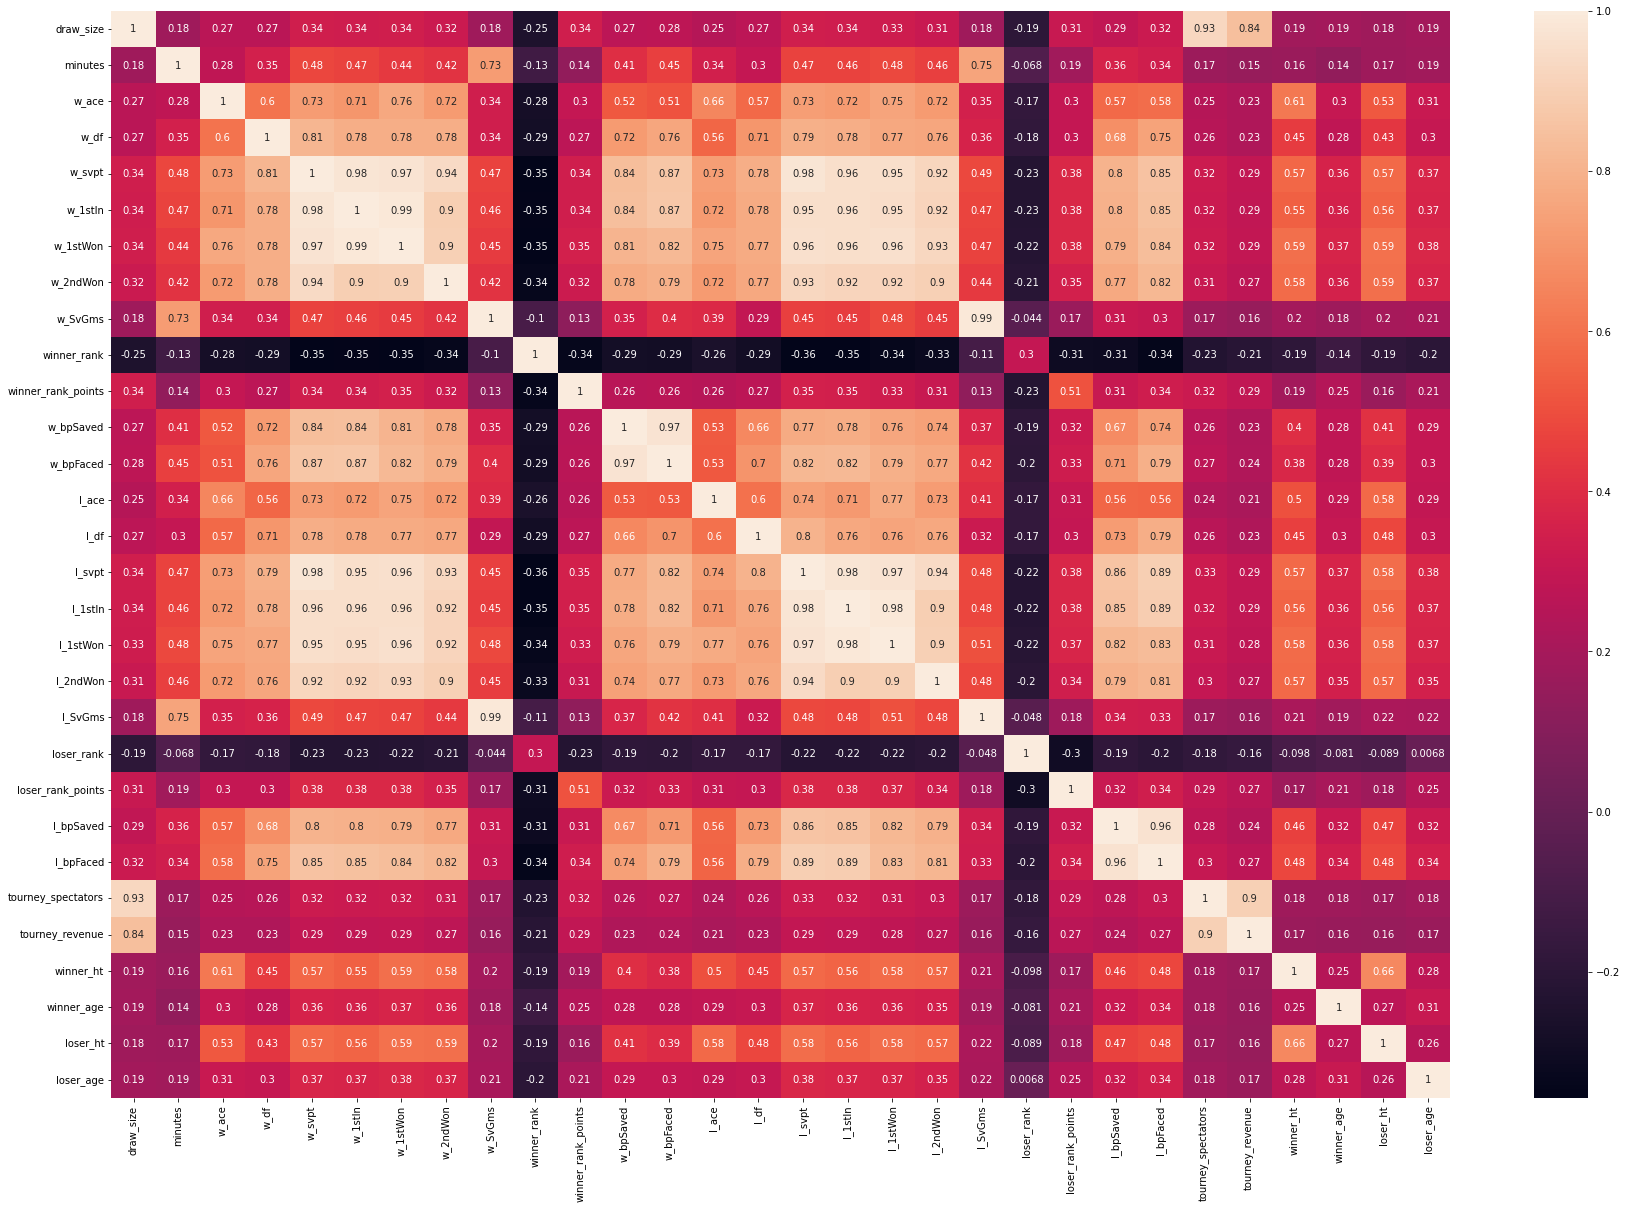

In [224]:
plt.figure(figsize = (30,20))
sns.heatmap(df_numeric.corr(), annot=True)

In [225]:
treshold = 0.85
correlation = df_numeric.corr()
correlation_filtered = correlation[correlation>treshold]
correlation_filtered = correlation[correlation_filtered.sum()>1]
correlation_filtered = correlation_filtered[correlation_filtered>treshold]
correlation_filtered = correlation_filtered.dropna(axis=1,how='all')
correlation_filtered

,draw_size,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_spectators,tourney_revenue
draw_size,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.929383,NaN
w_svpt,NaN,1.000000,0.976632,0.972884,0.940473,NaN,NaN,0.865641,0.976066,0.956154,0.954291,0.922232,NaN,NaN,0.852169,NaN,NaN
w_1stIn,NaN,0.976632,1.000000,0.988505,0.896743,NaN,NaN,0.869811,0.954614,0.956336,0.951610,0.915401,NaN,NaN,0.850905,NaN,NaN
w_1stWon,NaN,0.972884,0.988505,1.000000,0.903207,NaN,NaN,NaN,0.958755,0.956764,0.961650,0.926179,NaN,NaN,NaN,NaN,NaN
w_2ndWon,NaN,0.940473,0.896743,0.903207,1.000000,NaN,NaN,NaN,0.928547,0.916086,0.920215,0.904004,NaN,NaN,NaN,NaN,NaN
w_SvGms,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.985177,NaN,NaN,NaN,NaN
w_bpSaved,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.969426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w_bpFaced,NaN,0.865641,0.869811,NaN,NaN,NaN,0.969426,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
l_svpt,NaN,0.976066,0.954614,0.958755,0.928547,NaN,NaN,NaN,1.000000,0.978774,0.971432,0.937677,NaN,0.858696,0.894410,NaN,NaN
l_1stIn,NaN,0.956154,0.956336,0.956764,0.916086,NaN,NaN,NaN,0.978774,1.000000,0.984208,0.897438,NaN,0.853945,0.888865,NaN,NaN


From https://it.wikipedia.org/wiki/Glossario_del_tennis:
**Breakpoint** - situazione nella quale il giocatore in risposta si trova ad un punto dal vincere il game in cui l'avversario è al servizio.

**w_svpt, w_1stIn, w_1stWon, w_2ndWon** are all correlated because the first serves and the second serve are a part of service points. So if the service points increase the the first services and the second services increase with them.
So more w_svpt increase and more w_1stIn increase. More w_1stIn increase and more is the probability that w_1stWon increase too because more a first serves a player do and more first serves ze can won. The same reasoning is done for w_2ndWon. More service point (w_svpt) a player do and more second serves can ben done and consequences can be won. The same reasoning is done for **l_svpt, l_1stIn, l_1stWon, l_2ndWon**

**w_svpt, w_1stIn, w_1stWon, w_2ndWon, l_svpt, l_1stIn, l_1stWon, l_2ndWon**  The same reasoning of before is done but winner and loser attributes are correlated because the serves are alternated in games, so more services a winner do and more a services a loser do.

**w_bpFaced, w_svpt, w_1stIn, l_svpt, l_1stIn** are all correlated because, the increasing number of service points by the players can be interpreted in two ways: 1. the players make more services in few games reaching many times a draw and this as consequences lead to have many breakpoints because in case of draw we have a breakpoint wvery time a point by a player is done after the draw. 2. The players play many games and to win a game a player must reach the situation where he need only one point to win. So, a breakpoint, to win a game, is present for sure.
So, for these reason, more service points are done by the players and more breakpoints increase. These columns are correlated also to w_1stIn and l_1stIn because to serve a point a players must done a first serve. This reasoning is done also for **l_bpFaced**.

**w_bpSaved, w_bpFaced** are correlated because more are the breakpoints faced and more can be the breakpoint saved.  The same reasoning is done also for the loser  **l_bpSaved, l_bpFaced**.

**w_SvGms, l_SvGms** are correlated because the service is alterned between the winner and loser player by games (the serves approximately the same number of games in a match. So, if w_SvGms increase also l_SvGms increase (cannot have high w_SvGms and low l_SvGms or viceversa because of tennis rules).

**draw_size**, **tourney_revenue**, **tourney_spectators** are all correlated. This can be interpreted as the fact that the tourneys with more players attract more people to see the matches and have a bigger budget respect to the the tourneys with less players.

In [226]:
correlation_filtered = correlation[correlation<-treshold]
correlation_filtered = correlation_filtered[correlation_filtered<-treshold]
correlation_filtered.dropna(axis=1,how='all',inplace=True)
correlation_filtered

""
draw_size
minutes
w_ace
w_df
w_svpt
w_1stIn
w_1stWon
w_2ndWon
w_SvGms
winner_rank
